# Context

## Challenge
In this challenge, you are given a list of users along with their demographics, web session records, and some summary statistics. You are asked to predict which country a new user's first booking destination will be. All the users in this dataset are from the USA.

There are 12 possible outcomes of the destination country: 'US', 'FR', 'CA', 'GB', 'ES', 'IT', 'PT', 'NL','DE', 'AU', 'NDF' (no destination found), and 'other'. Please note that 'NDF' is different from 'other' because 'other' means there was a booking, but is to a country not included in the list, while 'NDF' means there wasn't a booking.

The training and test sets are split by dates. In the test set, you will predict all the new users with first activities after 7/1/2014 (note: this is updated on 12/5/15 when the competition restarted). In the sessions dataset, the data only dates back to 1/1/2014, while the users dataset dates back to 2010. 

File descriptions

# train_users.csv - the training set of users

# test_users.csv - the test set of users

id: user id

date_account_created: the date of account creation

timestamp_first_active: timestamp of the first activity, note that it can be earlier than date_account_created or date_first_booking because a user can search before signing up

date_first_booking: date of first booking

gender

age

signup_method

signup_flow: the page a user came to signup up from

language: international language preference

affiliate_channel: what kind of paid marketing

affiliate_provider: where the marketing is e.g. google, craigslist, other

first_affiliate_tracked: whats the first marketing the user interacted with before the signing up

signup_app

first_device_type

first_browser

country_destination: this is the target variable you are to predict

# sessions.csv - web sessions log for users

user_id: to be joined with the column 'id' in users table

action

action_type

action_detail

device_type

secs_elapsed

countries.csv - summary statistics of destination countries in this dataset and their locations

age_gender_bkts.csv - summary statistics of users' age group, gender, country of destination

sample_submission.csv - correct format for submitting your predictions


# 1. Imports

## 1.1. Libraries

In [1]:
# Jupyter settings
from IPython.core.display      import display, HTML
from IPython.display           import Image

# data manipulation
import inflection
import datetime
import math
import random
import numpy as np
import pandas as pd
from scipy import stats as ss

# EDA
import pandas_profiling as pr
import seaborn as sns
import matplotlib.pyplot as plt

# feature selection
from boruta import BorutaPy

# balancing
from imblearn   import combine         as c

# ML preprocessing, models and metrics
from sklearn import model_selection as ms
from sklearn import preprocessing   as pp
from category_encoders import TargetEncoder
from sklearn import metrics         as m
from scikitplot import metrics      as mt

from sklearn import linear_model as lm
from sklearn import neighbors as nh
from sklearn import ensemble as en
from sklearn import svm
from sklearn import tree
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

# neural nets
from keras import models as ml
from keras import layers as l

## 1.2. Helper Functions

In [2]:
# jupyter setup
def jupyter_settings():
    
    # jupyter core settings
    display(HTML("<style>.container { width:100% !important; }</style>"))
    !pylab inline
    
    # pandas
    pd.set_option('display.max_rows', 500)
    pd.set_option('display.max_columns', 500)
    pd.set_option('display.expand_frame_repr', False)
    
    # matplotlib
    !matplotlib inline
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [35, 12]
    plt.rcParams['font.size'] = 30
    
    # seaborn
    sns.set()
    
    
# descriptive analysis summary for numerical features
def num_analysis(num_attributes):
    # Cemtral tendency - mean, median
    ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
    ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

    # Dispersion - std, min, max, range, skew, kurtosis
    d1 = pd.DataFrame(num_attributes.apply(np.std)).T
    d2 = pd.DataFrame(num_attributes.apply(min)).T
    d3 = pd.DataFrame(num_attributes.apply(max)).T
    d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

    # concatenate
    m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
    m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis',]
    
    # histogram
    hist = num_attributes.hist(bins=30)
    
    return m

    return hist


def cramer_v (x,y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1,rcorr-1)))

def classif_metrics(yvalidation, yhat):
    m_result = {}
    m_result['accuracy'] = m.accuracy_score(yvalidation, yhat)
    m_result['balanced_accuracy'] = m.balanced_accuracy_score(yvalidation, yhat)
    m_result['kappa_score'] = m.cohen_kappa_score(yvalidation, yhat)
    
    return m_result

def cross_validation_classification(df5, model_name, model):
    acc_list = []
    bal_acc_list = []
    kappa_list = []
    for i in range(0,5):  
        # beggining and end of validation set in df
        initial_val = int(df5.shape[0]/5)*i
        end_val = int(df5.shape[0]/5)*(i+1)
        
        # filtering dataset
        training = df5.drop(df5.index[initial_val:end_val])
        validation = df5[initial_val:end_val]
        
        # training
        xtraining = training.drop('country_destination', axis=1)
        ytraining = training['country_destination'].copy()
        
        # validation
        xvalidation = validation.drop('country_destination', axis=1)
        yvalidation = validation['country_destination']
        
        # model
        model = model.fit(xtraining, ytraining)
        
        # prediction
        yhat = model.predict(xvalidation)
        
        # performance
        m_result = classif_metrics(yvalidation, yhat)
        
        # store performance of each kfold iteration
        acc_list.append(m_result['accuracy'])
        bal_acc_list.append(m_result['balanced_accuracy'])
        kappa_list.append(m_result['kappa_score'])
        
    return pd.DataFrame({'Model Name': model_name, 
                         'Accuracy': np.round(np.mean(acc_list), 3).astype(str) + '+-' + np.round(np.std(acc_list), 3).astype(str),
                         'Balanced Accuracy': np.round(np.mean(bal_acc_list), 3).astype(str) + '+-' + np.round(np.std(bal_acc_list), 3).astype(str),
                         'Kappa´s Score': np.round(np.mean(kappa_list), 3).astype(str) + '+-' + np.round(np.std(kappa_list), 3).astype(str)}, index=[0])

def cv_performance_models(data, classifiers):
    # build dataframe
    df = pd.DataFrame()
    for i, j in classifiers:
        cv = cross_validation_classification(data, i, j)
        df = pd.concat([df, cv], axis=0)
        
    # return DataFrame
    return df

In [3]:
jupyter_settings()

'pylab' nÆo ‚ reconhecido como um comando interno
ou externo, um programa oper vel ou um arquivo em lotes.
'matplotlib' nÆo ‚ reconhecido como um comando interno
ou externo, um programa oper vel ou um arquivo em lotes.


## 1.3. Data

In [7]:
# train_users_2

df_raw = pd.read_csv('data/train_users_2.csv')
df_raw.shape

(213451, 16)

In [12]:
# sessions

df_sessions = pd.read_csv('data/sessions.csv')
df_sessions.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


In [13]:
# granulariadade, cada usuario realiza varias ações, como registrado no csv 'sessions'
df_sessions.sort_values('user_id').head()
# cada ação pode ser convertida a uma nova variável, com indicação de ocorrência ou não por parte do usuário

,user_id,action,action_type,action_detail,device_type,secs_elapsed
3573962,00023iyk9l,personalize,data,wishlist_content_update,Mac Desktop,1767.0
3573933,00023iyk9l,requested,view,p5,Mac Desktop,702.0
3573934,00023iyk9l,requested,view,p5,Mac Desktop,3827.0
3573935,00023iyk9l,travel_plans_current,view,your_trips,Mac Desktop,474.0
3573949,00023iyk9l,personalize,data,wishlist_content_update,Mac Desktop,922.0


In [14]:
df_sessions[df_sessions['user_id'] == '00023iyk9l'][['user_id', 'action']].groupby('user_id').count()

,action
user_id,
00023iyk9l,39


In [15]:
pd.DataFrame(df_sessions[df_sessions['user_id'] == '00023iyk9l'][['user_id', 'action']].value_counts()).T

user_id 00023iyk9l                                                                                                                                                               
action        show requested personalize index dashboard similar_listings travel_plans_current header_userpic ajax_refresh_subtotal search_results pending confirm_email callback
0                9         5           4     4         4                3                    2              2                     2              1       1             1        1

# 2. Descriptive analysis

In [8]:
df1 = df_raw.copy()
df1

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213446,zxodksqpep,2014-06-30,20140630235636,NaN,MALE,32.0,basic,0,en,sem-brand,google,omg,Web,Mac Desktop,Safari,NDF
213447,mhewnxesx9,2014-06-30,20140630235719,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome,NDF
213448,6o3arsjbb4,2014-06-30,20140630235754,NaN,-unknown-,32.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,NDF
213449,jh95kwisub,2014-06-30,20140630235822,NaN,-unknown-,NaN,basic,25,en,other,other,tracked-other,iOS,iPhone,Mobile Safari,NDF


In [9]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 213451
Number of Columns: 16


In [10]:
df1['country_destination'].value_counts(normalize=True)

NDF      0.583473
US       0.292226
other    0.047290
FR       0.023532
IT       0.013282
GB       0.010888
ES       0.010536
CA       0.006690
DE       0.004971
NL       0.003570
AU       0.002525
PT       0.001017
Name: country_destination, dtype: float64

In [14]:
df1.isna().sum() / len(df1)

# date_first_booking         
# age         
# first_affiliate_tracked    

id                         0.000000
date_account_created       0.000000
timestamp_first_active     0.000000
date_first_booking         0.583473
gender                     0.000000
age                        0.412226
signup_method              0.000000
signup_flow                0.000000
language                   0.000000
affiliate_channel          0.000000
affiliate_provider         0.000000
first_affiliate_tracked    0.028414
signup_app                 0.000000
first_device_type          0.000000
first_browser              0.000000
country_destination        0.000000
dtype: float64

## Fill NA

In [11]:
# ========================= Users ===========================
# date_first_booking   : the maximum datetime value is correspondent to what would be the current present date, in this dataset it is 2015-06-29
date_first_booking_max = pd.to_datetime(df1['date_first_booking']).max().strftime('%Y-%m-%d')
df1['date_first_booking'] = df1['date_first_booking'].fillna(date_first_booking_max)

# age         
df1 = df1[(df1['age']>15) & (df1['age']<120)]
avg_age = df1['age'].mean().astype(int)
df1['age'] = df1['age'].fillna(avg_age)

# first_affiliate_tracked   
df1 = df1[~df1['first_affiliate_tracked'].isna()]

<ipython-input-11-a2634023f3a5>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['age'] = df1['age'].fillna(avg_age)


### Data Types

In [16]:
df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

In [12]:
df1['date_account_created'] = pd.to_datetime(df1['date_account_created'])       
df1['timestamp_first_active'] = pd.to_datetime(df1['timestamp_first_active'], format = '%Y%m%d%H%M%S')         
df1['date_first_booking'] = pd.to_datetime(df1['date_first_booking'])  
df1['age'] = df1['age'].astype(int)

In [18]:
df1.dtypes

id                                 object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
date_first_booking         datetime64[ns]
gender                             object
age                                 int32
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
dtype: object

In [19]:
# Users
num_attributes = df1.select_dtypes( include=['int64', 'float64', 'int32'] )
cat_attributes = df1.select_dtypes( include=['object'] )
time_attributes = df1.select_dtypes( include=['datetime64[ns]'] )

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,age,16.0,115.0,99.0,37.405591,34.0,13.939844,2.089718,6.516468
1,signup_flow,0.0,25.0,25.0,2.519513,0.0,6.604696,2.705871,5.928298


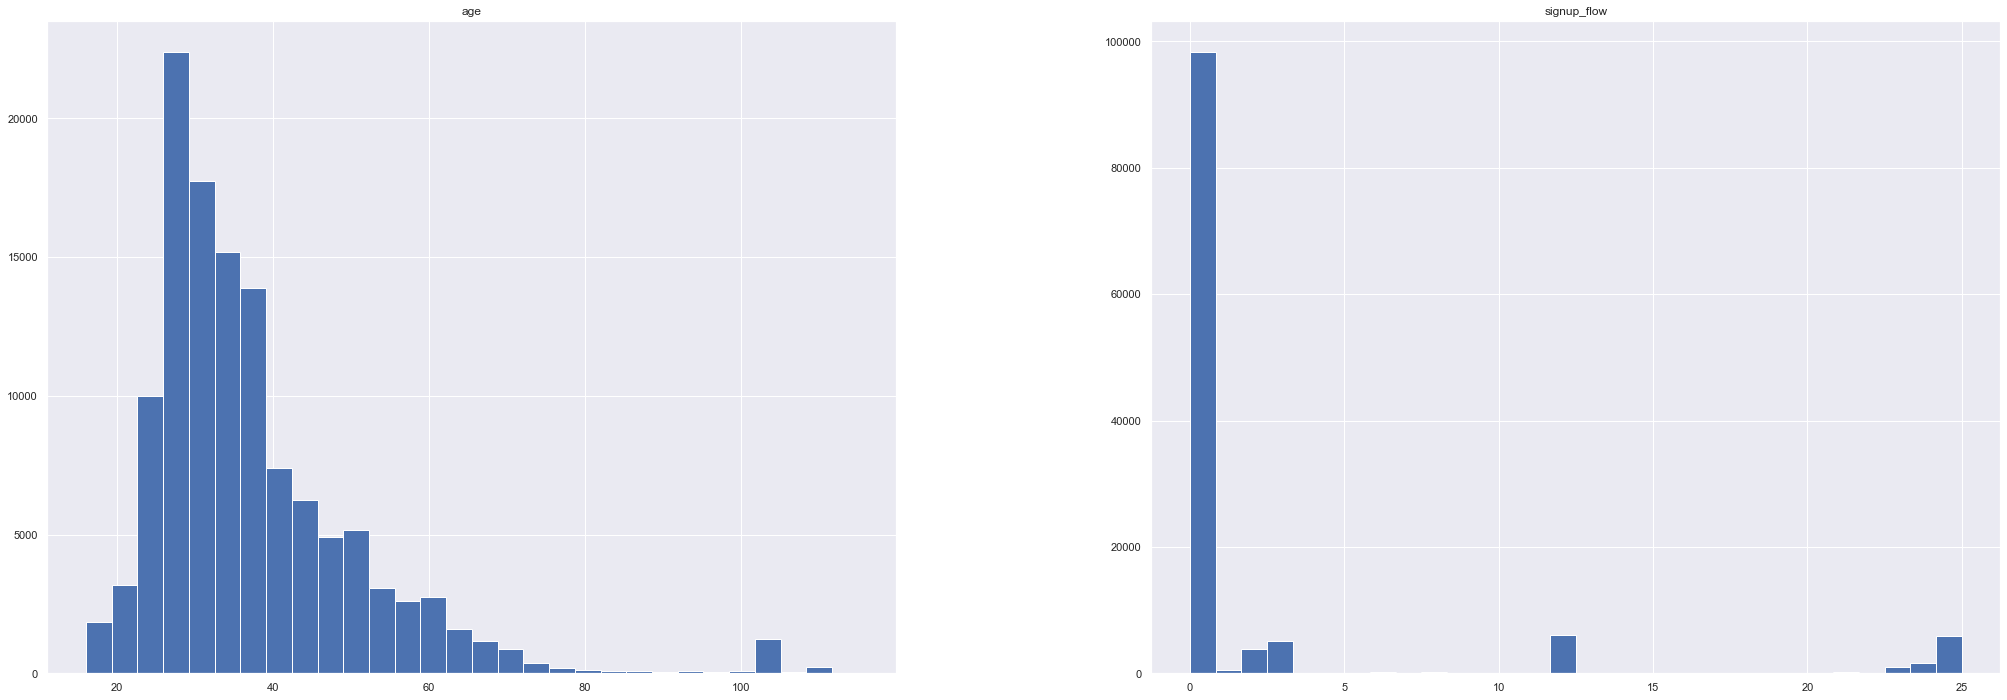

In [20]:
num_analysis(num_attributes)

In [21]:
cat_attributes.drop('id', axis=1).describe()

,gender,signup_method,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
count,122636,122636,122636,122636,122636,122636,122636,122636,122636,122636
unique,4,3,25,8,17,7,4,9,41,12
top,FEMALE,basic,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
freq,56362,66039,118205,79093,78954,64712,108283,57943,41778,54852


In [22]:
cat_attributes['gender'].unique()

array(['MALE', 'FEMALE', '-unknown-', 'OTHER'], dtype=object)

In [23]:
cat_attributes['language'].unique()

array(['en', 'de', 'fr', 'es', 'zh', 'ko', 'it', 'ru', 'ja', 'pt', 'nl',
       'sv', 'pl', 'hu', 'da', 'id', 'fi', 'no', 'tr', 'el', 'th', 'cs',
       'hr', 'ca', 'is'], dtype=object)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'Mac Desktop'),
  Text(1, 0, 'Windows Desktop'),
  Text(2, 0, 'iPhone'),
  Text(3, 0, 'Desktop (Other)'),
  Text(4, 0, 'Android Tablet'),
  Text(5, 0, 'Other/Unknown'),
  Text(6, 0, 'iPad'),
  Text(7, 0, 'Android Phone'),
  Text(8, 0, 'SmartPhone (Other)')])

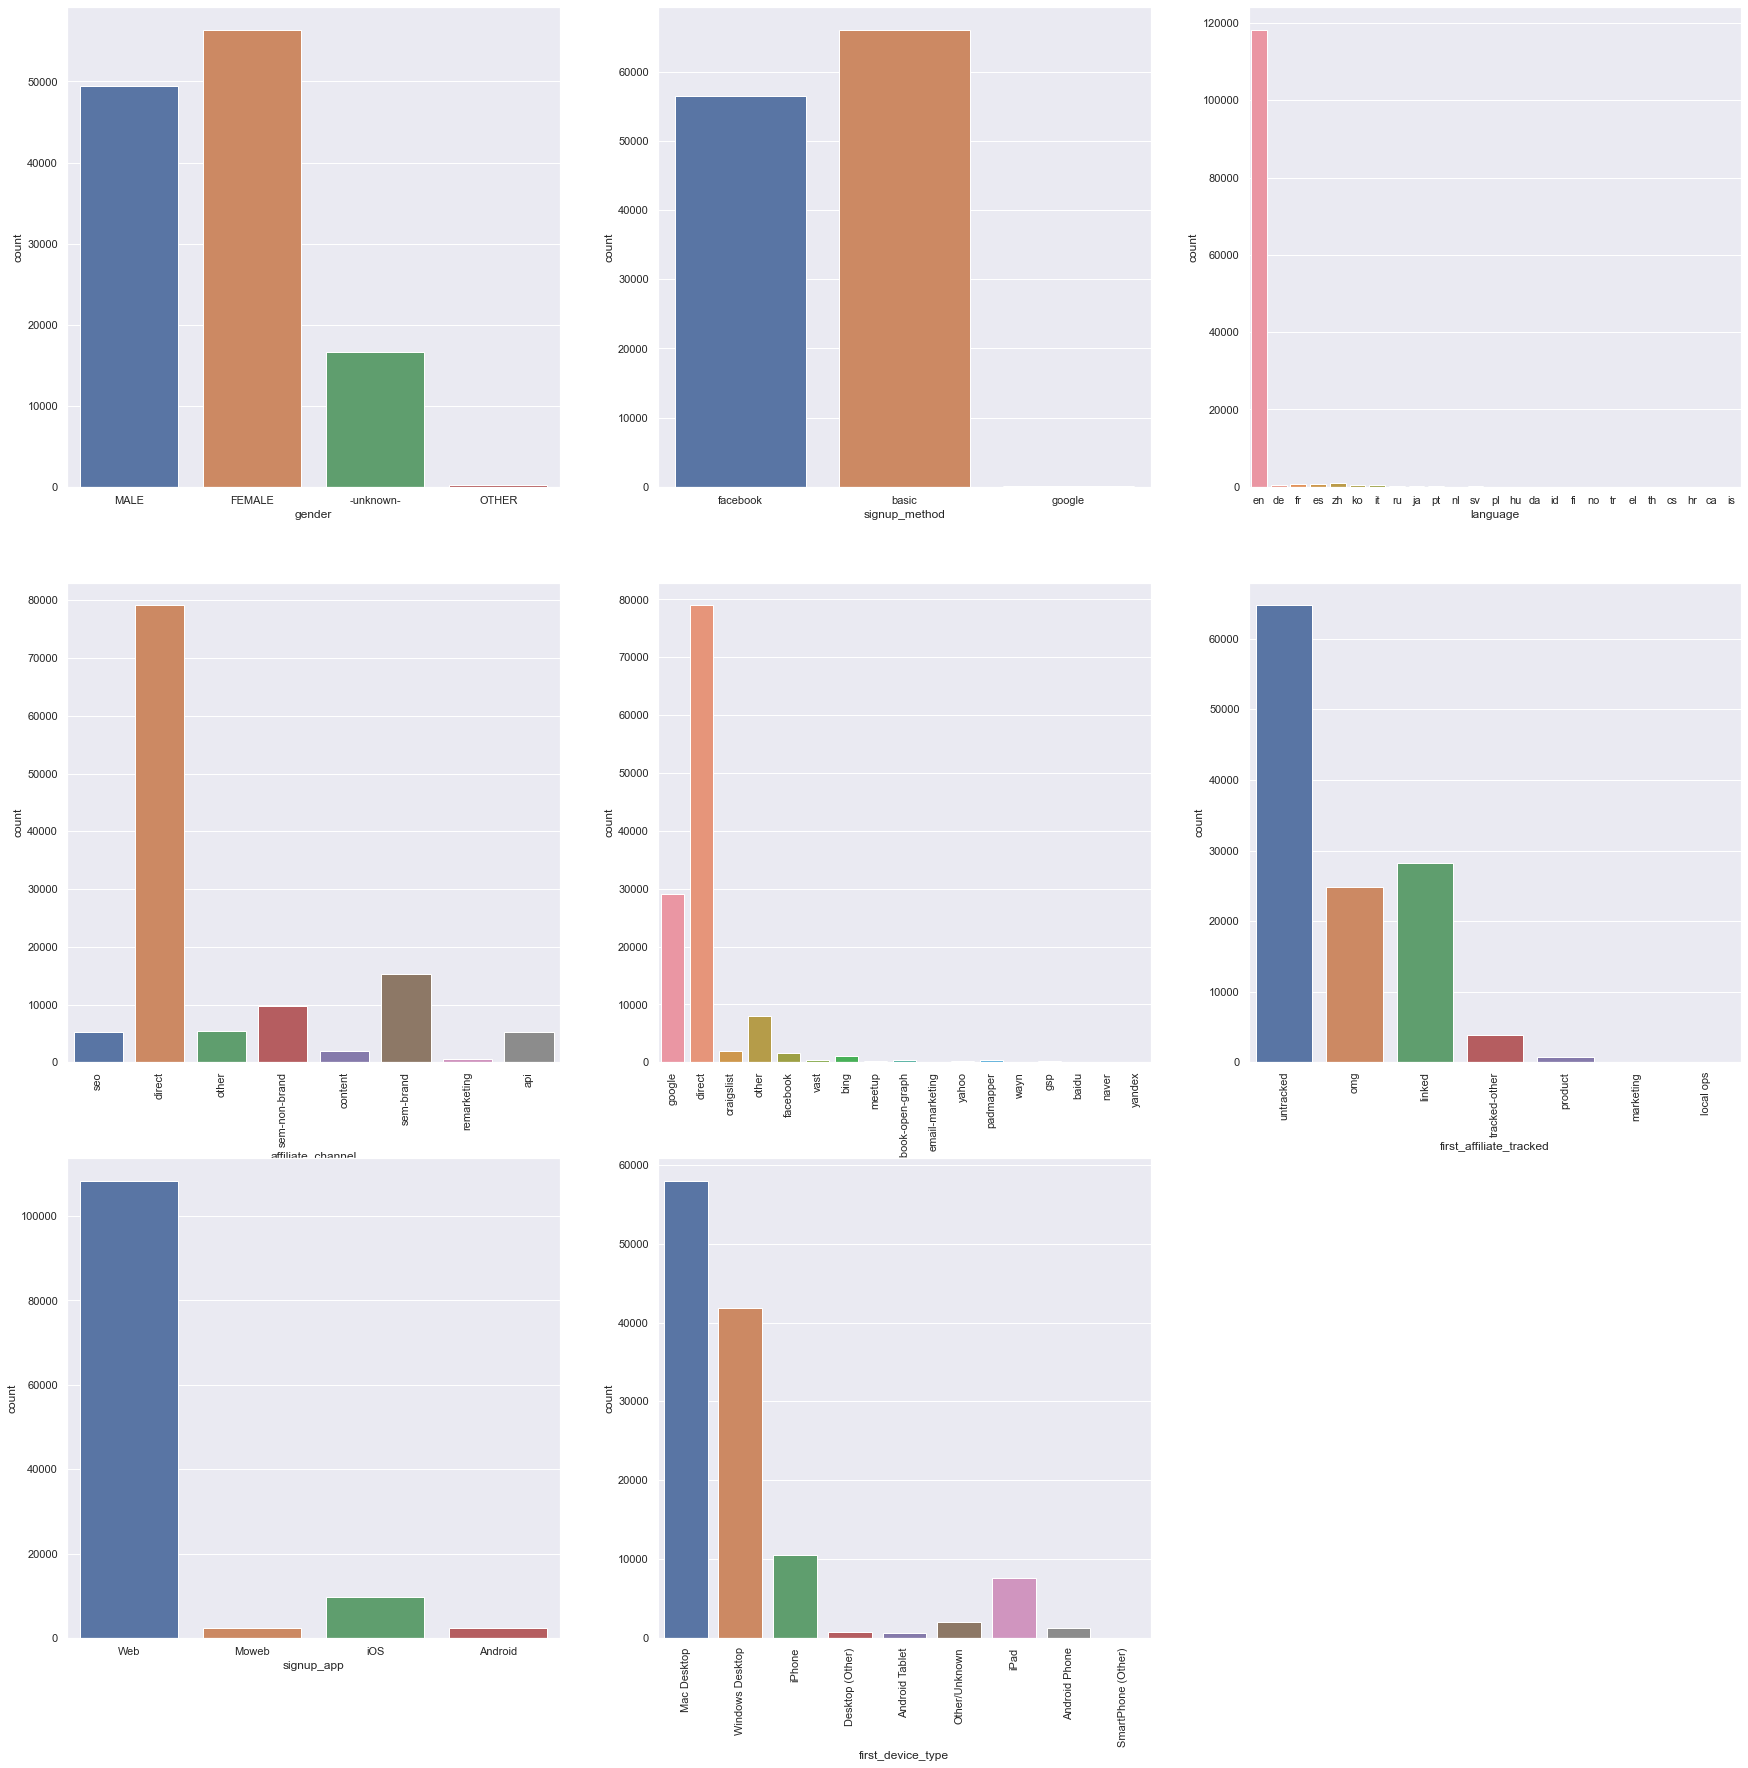

In [32]:
plt.figure(figsize=(30, 30))
plt.xticks()

plt.subplot(3,3,1)
sns.countplot(x='gender',data=cat_attributes)

plt.subplot(3,3,2)
sns.countplot(x='signup_method',data=cat_attributes)

plt.subplot(3,3,3)
sns.countplot(x='language',data=cat_attributes)

plt.subplot(3,3,4)
sns.countplot(x='affiliate_channel',data=cat_attributes)
plt.xticks(rotation=90)

plt.subplot(3,3,5)
sns.countplot(x='affiliate_provider',data=cat_attributes)
plt.xticks(rotation=90)

plt.subplot(3,3,6)
sns.countplot(x='first_affiliate_tracked',data=cat_attributes)
plt.xticks(rotation=90)

plt.subplot(3,3,7)
sns.countplot(x='signup_app',data=cat_attributes)

plt.subplot(3,3,8)
sns.countplot(x='first_device_type',data=cat_attributes)
plt.xticks(rotation=90)

<AxesSubplot:xlabel='country_destination', ylabel='count'>

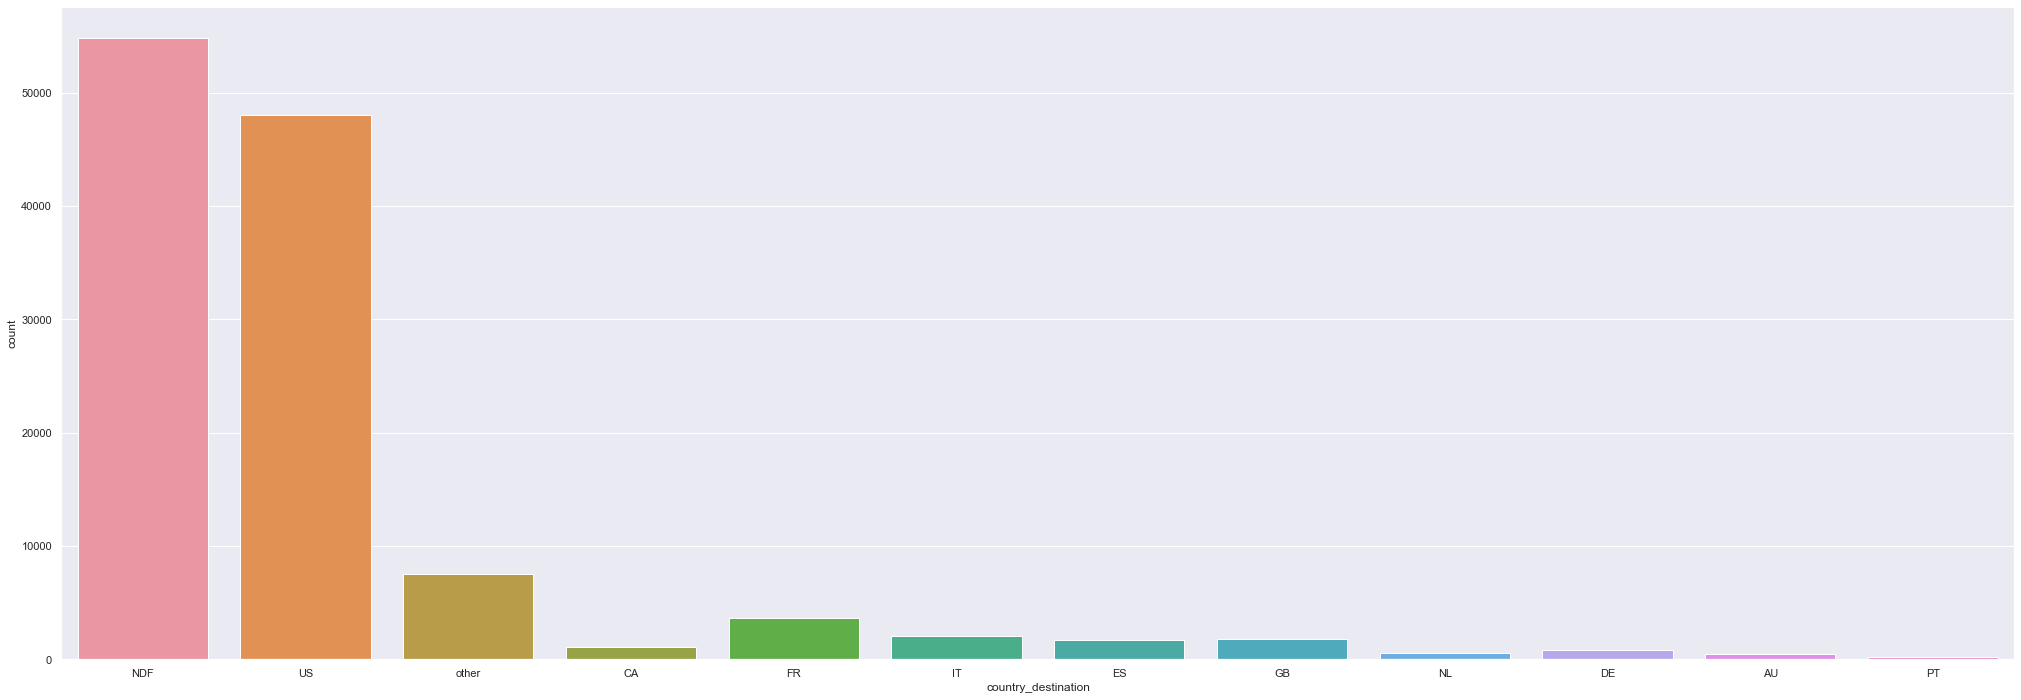

In [33]:
sns.countplot(x='country_destination',data=cat_attributes)

c:\users\lucas\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='language', ylabel='count'>

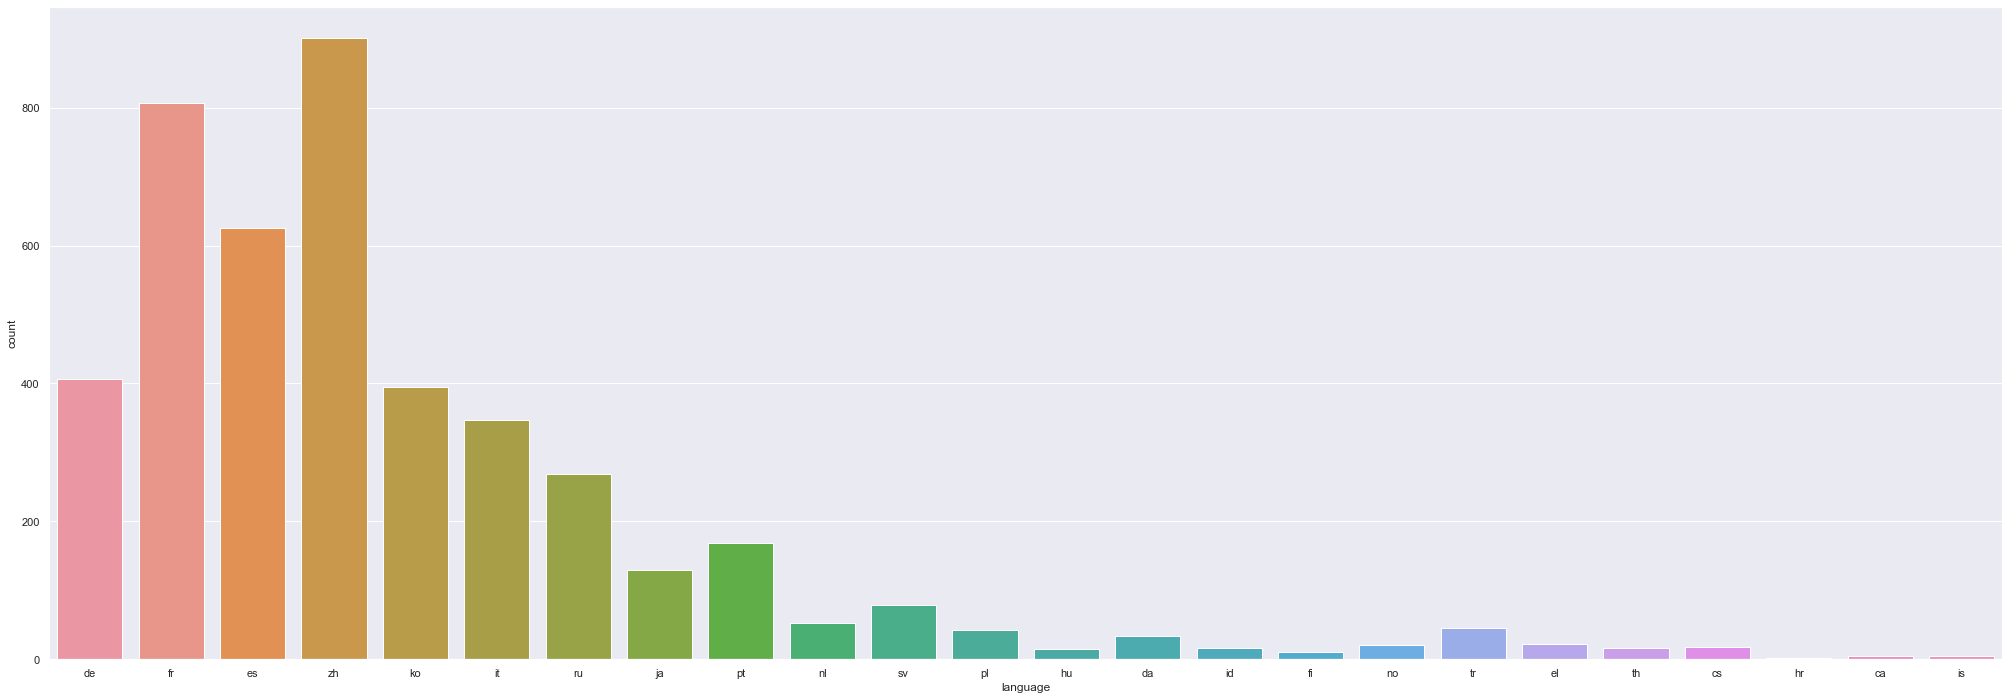

In [34]:
aux = cat_attributes['language'][cat_attributes['language'] != 'en']
sns.countplot(aux)

In [35]:
time_attributes.describe()

<ipython-input-35-6d2f1968cb9d>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  time_attributes.describe()
<ipython-input-35-6d2f1968cb9d>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  time_attributes.describe()
<ipython-input-35-6d2f1968cb9d>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  time_attributes.describe()


,date_account_created,timestamp_first_active,date_first_booking
count,122636,122636,122636
unique,1617,122636,1938
top,2014-06-24 00:00:00,2013-07-02 18:05:32,2015-06-29 00:00:00
freq,368,1,54853
first,2010-01-02 00:00:00,2009-05-23 17:48:09,2010-01-04 00:00:00
last,2014-06-30 00:00:00,2014-06-30 23:57:54,2015-06-29 00:00:00


In [36]:
cat_list = cat_attributes.drop('id', axis=1).columns.tolist()
corr_dict = {}

for i in range(len(cat_list)):
    corr_list = []
    for j in range(len(cat_list)):
        ref = cat_list[i]
        feat = cat_list[j]
        
        # correlation
        corr = cramer_v (cat_attributes[ref], cat_attributes[feat])
        
        # append a list
        corr_list.append(corr)
        
    # append a correlation list for each ref attributes
    corr_dict[ref] = corr_list

<AxesSubplot:>

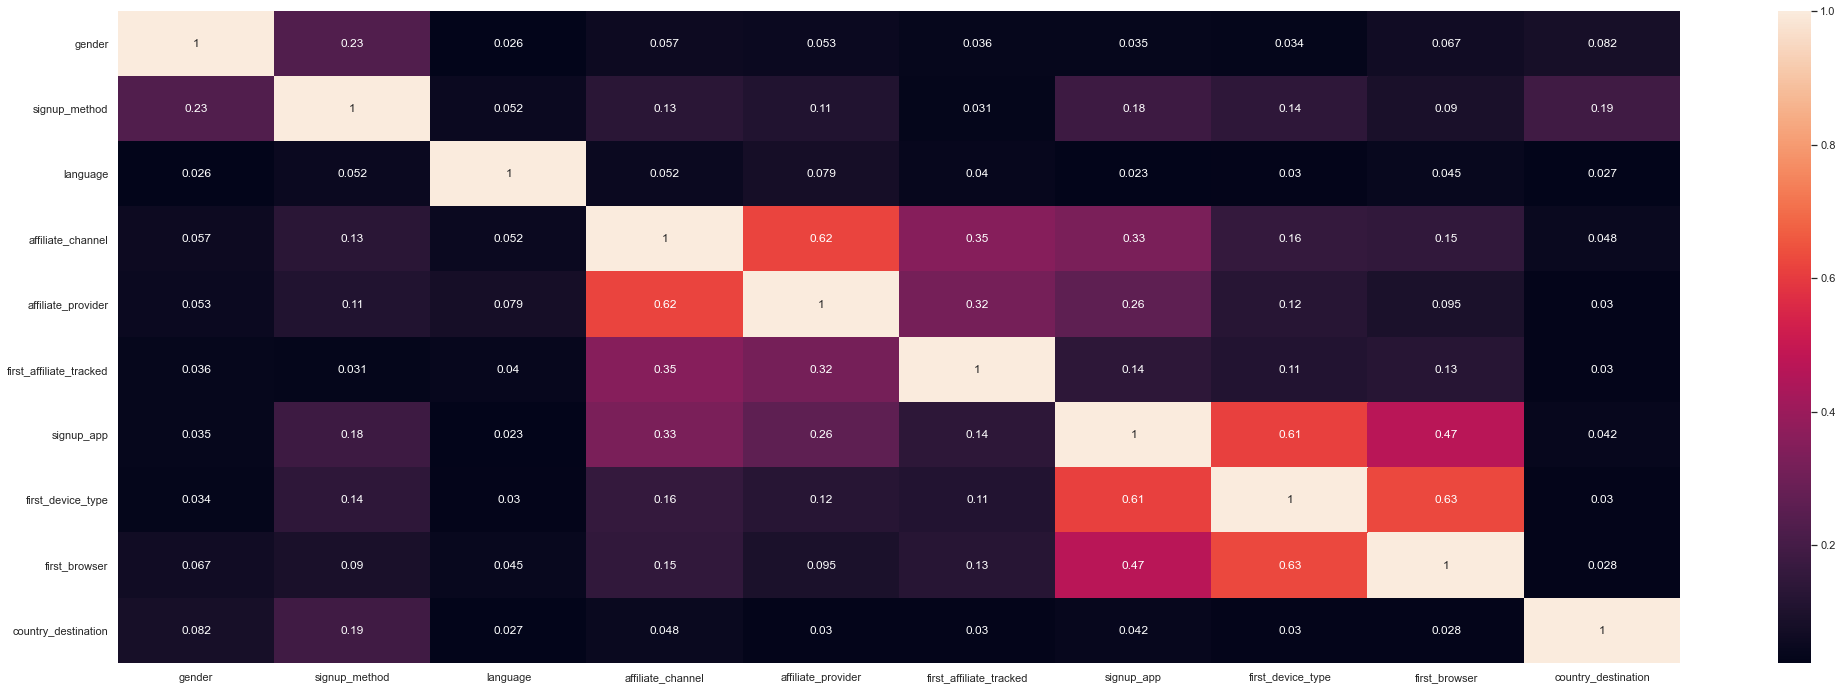

In [37]:
d = pd.DataFrame(corr_dict)
d = d.set_index(d.columns)
sns.heatmap(d, annot=True)

# 3. Feature Engineering

In [13]:
df2 = df1.copy()

In [14]:
df2.dtypes

id                                 object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
date_first_booking         datetime64[ns]
gender                             object
age                                 int32
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
dtype: object

In [26]:
df2[['date_account_created', 'timestamp_first_active', 'date_first_booking']].describe()

<ipython-input-26-a6921e7b3dc6>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df2[['date_account_created', 'timestamp_first_active', 'date_first_booking']].describe()
<ipython-input-26-a6921e7b3dc6>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df2[['date_account_created', 'timestamp_first_active', 'date_first_booking']].describe()
<ipython-input-26-a6921e7b3dc6>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and ado

,date_account_created,timestamp_first_active,date_first_booking
count,122636,122636,122636
unique,1617,122636,1938
top,2014-06-24 00:00:00,2013-07-02 18:05:32,2015-06-29 00:00:00
freq,368,1,54853
first,2010-01-02 00:00:00,2009-05-23 17:48:09,2010-01-04 00:00:00
last,2014-06-30 00:00:00,2014-06-30 23:57:54,2015-06-29 00:00:00


In [27]:
pd.to_datetime(df2['timestamp_first_active'].dt.strftime('%Y-%m-%d'))

1        2009-05-23
2        2009-06-09
3        2009-10-31
4        2009-12-08
6        2010-01-02
            ...    
213441   2014-06-30
213443   2014-06-30
213445   2014-06-30
213446   2014-06-30
213448   2014-06-30
Name: timestamp_first_active, Length: 122636, dtype: datetime64[ns]

In [15]:
df2['first_active'] = pd.to_datetime(df2['timestamp_first_active'].dt.strftime('%Y-%m-%d'))

# creating new features from 'date_account_created', 'timestamp_first_active', 'date_first_booking'
df2['days_from_first_active_until_booking'] = (df2['date_first_booking'] - df2['first_active']).apply(lambda x: x.days)
df2['days_from_first_active_until_account_created'] = (df2['date_account_created'] - df2['first_active']).apply(lambda x: x.days)
df2['days_from_account_created_until_first_booking'] = (df2['date_first_booking'] - df2['date_account_created']).apply(lambda x: x.days)

# ================== First Active ==================
df2['year_first_active'] = df2['first_active'].dt.year
df2['month_first_active'] = df2['first_active'].dt.month
df2['day_first_active'] = df2['first_active'].dt.day
df2['day_of_week_first_active'] = df2['first_active'].dt.dayofweek
df2['week_of_year_first_active'] = df2['first_active'].dt.weekofyear

# ================== First Booking ==================
df2['year_first_booking'] = df2['date_first_booking'].dt.year
df2['month_first_booking'] = df2['date_first_booking'].dt.month
df2['day_first_booking'] = df2['date_first_booking'].dt.day
df2['day_of_week_first_booking'] = df2['date_first_booking'].dt.dayofweek
df2['week_of_year_first_booking'] = df2['date_first_booking'].dt.weekofyear

# ================== First Account Created ================
df2['year_account_created'] = df2['date_account_created'].dt.year
df2['month_account_created'] = df2['date_account_created'].dt.month
df2['day_account_created'] = df2['date_account_created'].dt.day
df2['day_of_week_account_created'] = df2['date_account_created'].dt.dayofweek
df2['week_of_year_account_created'] = df2['date_account_created'].dt.weekofyear

<ipython-input-15-856f72e1976a>:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df2['week_of_year_first_active'] = df2['first_active'].dt.weekofyear
<ipython-input-15-856f72e1976a>:20: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df2['week_of_year_first_booking'] = df2['date_first_booking'].dt.weekofyear
<ipython-input-15-856f72e1976a>:27: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df2['week_of_year_account_created'] = df2['date_account_created'].dt.weekofyear


# 4. Filter

In [16]:
df3 = df2.copy()
df3

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,first_active,days_from_first_active_until_booking,days_from_first_active_until_account_created,days_from_account_created_until_first_booking,year_first_active,month_first_active,day_first_active,day_of_week_first_active,week_of_year_first_active,year_first_booking,month_first_booking,day_first_booking,day_of_week_first_booking,week_of_year_first_booking,year_account_created,month_account_created,day_account_created,day_of_week_account_created,week_of_year_account_created
1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,2015-06-29,MALE,38,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF,2009-05-23,2228,732,1496,2009,5,23,5,21,2015,6,29,0,27,2011,5,25,2,21
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,2010-08-02,FEMALE,56,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US,2009-06-09,419,476,-57,2009,6,9,1,24,2010,8,2,0,31,2010,9,28,1,39
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,2012-09-08,FEMALE,42,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other,2009-10-31,1043,765,278,2009,10,31,5,44,2012,9,8,5,36,2011,12,5,0,49
4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,2010-02-18,-unknown-,41,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US,2009-12-08,72,280,-208,2009,12,8,1,50,2010,2,18,3,7,2010,9,14,1,37
6,lsw9q7uk0j,2010-01-02,2010-01-02 01:25:58,2010-01-05,FEMALE,46,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari,US,2010-01-02,3,0,3,2010,1,2,5,53,2010,1,5,1,1,2010,1,2,5,53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213441,omlc9iku7t,2014-06-30,2014-06-30 23:51:51,2014-08-13,FEMALE,34,basic,0,en,direct,direct,linked,Web,Mac Desktop,Chrome,ES,2014-06-30,44,0,44,2014,6,30,0,27,2014,8,13,2,33,2014,6,30,0,27
213443,0k26r3mir0,2014-06-30,2014-06-30 23:53:40,2014-07-13,FEMALE,36,basic,0,en,sem-brand,google,linked,Web,Mac Desktop,Safari,US,2014-06-30,13,0,13,2014,6,30,0,27,2014,7,13,6,28,2014,6,30,0,27
213445,qbxza0xojf,2014-06-30,2014-06-30 23:55:47,2014-07-02,FEMALE,23,basic,0,en,sem-brand,google,omg,Web,Windows Desktop,IE,US,2014-06-30,2,0,2,2014,6,30,0,27,2014,7,2,2,27,2014,6,30,0,27
213446,zxodksqpep,2014-06-30,2014-06-30 23:56:36,2015-06-29,MALE,32,basic,0,en,sem-brand,google,omg,Web,Mac Desktop,Safari,NDF,2014-06-30,364,0,364,2014,6,30,0,27,2015,6,29,0,27,2014,6,30,0,27


### 4.1. Filtering rows

In [17]:
df3 = df3[(df3['age'] > 15) & (df3['age'] < 120)]

### 4.2. Columns

In [18]:
 cols_drop = ['date_account_created', 'date_account_created', 'date_first_booking', 'timestamp_first_active', 'first_active'] # original datetime

In [19]:
# ===================== High Correlation between features justifies dropping columns before feature selection ===================== 
# days_from_first_active_until_booking x days_from_account_created_until_first_booking   # Remove: days_from_first_active_until_booking
# year_first_active x year_account_created                                               # Remove: year_first_active
# month_first_active x month_account_created                                             # Remove: month_first_active
# day_first_active x day_account_created                                                 # Remove: day_first_active
# day_of_week_first_active x day_of_week_account_created                                 # Remove: day_of_week_first_active
# week_of_year_first_active x week_of_year_account_created                               # Remove: week_of_year_first_active
# month_first_booking x week_of_year_first_booking                                       # Remove: month_first_booking
# month_account_created x week_of_year_account_created                                   # Remove: month_account_created
# year_first_booking x year_account_created                                              # Remove: year_first_booking
# week_of_year_first_booking x week_of_year_account_created                              # Remove: week_of_year_first_booking
# affiliate_channel x affiliate_provider                                                 # Remove: affiliate_provider
# first_device_type x first_browser                                                      # Remove: first_browser
#first_device_type x sigup_app                                                           # Remove: first_device_type

cols = [ 'days_from_first_active_until_booking',  'year_first_active',  'month_first_active', 'day_first_active',
        'day_of_week_first_active', 'week_of_year_first_active', 'month_first_booking', 'month_account_created',
        'year_first_booking', 'week_of_year_first_booking', 'affiliate_provider',
        'first_browser', 'first_device_type', 'language'] # high correlation

In [20]:
cols_all = cols + cols_drop
df3 = df3.drop(cols_all, axis=1)

# 5. Data Preparation

In [21]:
df5 = df3.copy()
df5

,id,gender,age,signup_method,signup_flow,affiliate_channel,first_affiliate_tracked,signup_app,country_destination,days_from_first_active_until_account_created,days_from_account_created_until_first_booking,day_first_booking,day_of_week_first_booking,year_account_created,day_account_created,day_of_week_account_created,week_of_year_account_created
1,820tgsjxq7,MALE,38,facebook,0,seo,untracked,Web,NDF,732,1496,29,0,2011,25,2,21
2,4ft3gnwmtx,FEMALE,56,basic,3,direct,untracked,Web,US,476,-57,2,0,2010,28,1,39
3,bjjt8pjhuk,FEMALE,42,facebook,0,direct,untracked,Web,other,765,278,8,5,2011,5,0,49
4,87mebub9p4,-unknown-,41,basic,0,direct,untracked,Web,US,280,-208,18,3,2010,14,1,37
6,lsw9q7uk0j,FEMALE,46,basic,0,other,untracked,Web,US,0,3,5,1,2010,2,5,53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213441,omlc9iku7t,FEMALE,34,basic,0,direct,linked,Web,ES,0,44,13,2,2014,30,0,27
213443,0k26r3mir0,FEMALE,36,basic,0,sem-brand,linked,Web,US,0,13,13,6,2014,30,0,27
213445,qbxza0xojf,FEMALE,23,basic,0,sem-brand,omg,Web,US,0,2,2,2,2014,30,0,27
213446,zxodksqpep,MALE,32,basic,0,sem-brand,omg,Web,NDF,0,364,29,0,2014,30,0,27


In [22]:
# df5.to_csv('df5.csv')
# df5 = pd.read_csv('df5.csv')

### Rescaling

In [23]:
ss = pp.StandardScaler()
rs = pp.RobustScaler()
mms = pp.MinMaxScaler() 

# Standardization
df5['age'] = ss.fit_transform(df5[['age']].values)

# Robust Scaler
df5['signup_flow'] = rs.fit_transform(df5[['signup_flow']].values)
df5['days_from_first_active_until_account_created'] = rs.fit_transform(df5[['days_from_first_active_until_account_created']].values)
df5['days_from_account_created_until_first_booking'] = rs.fit_transform(df5[['days_from_account_created_until_first_booking']].values)

# MinMax Scaler
df5['year_account_created'] = mms.fit_transform(df5[['year_account_created']].values)

### Encoding

In [24]:
ohe = pp.OneHotEncoder()

# gender - One Hot Encoder
df5 = pd.get_dummies(df5, prefix=['gender'], columns=['gender'])
df5 = pd.get_dummies(df5, prefix=['signup_method'], columns=['signup_method'])
df5 = pd.get_dummies(df5, prefix=['signup_app'], columns=['signup_app'])

In [25]:
df5

,id,age,signup_flow,affiliate_channel,first_affiliate_tracked,country_destination,days_from_first_active_until_account_created,days_from_account_created_until_first_booking,day_first_booking,day_of_week_first_booking,year_account_created,day_account_created,day_of_week_account_created,week_of_year_account_created,gender_-unknown-,gender_FEMALE,gender_MALE,gender_OTHER,signup_method_basic,signup_method_facebook,signup_method_google,signup_app_Android,signup_app_Moweb,signup_app_Web,signup_app_iOS
1,820tgsjxq7,0.042641,0.0,seo,untracked,NDF,732.0,2.053140,29,0,0.25,25,2,21,0,0,1,0,0,1,0,0,0,1,0
2,4ft3gnwmtx,1.333904,3.0,direct,untracked,US,476.0,-0.447665,2,0,0.00,28,1,39,0,1,0,0,1,0,0,0,0,1,0
3,bjjt8pjhuk,0.329588,0.0,direct,untracked,other,765.0,0.091787,8,5,0.25,5,0,49,0,1,0,0,0,1,0,0,0,1,0
4,87mebub9p4,0.257851,0.0,direct,untracked,US,280.0,-0.690821,18,3,0.00,14,1,37,1,0,0,0,1,0,0,0,0,1,0
6,lsw9q7uk0j,0.616536,0.0,other,untracked,US,0.0,-0.351047,5,1,0.00,2,5,53,0,1,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213441,omlc9iku7t,-0.244306,0.0,direct,linked,ES,0.0,-0.285024,13,2,1.00,30,0,27,0,1,0,0,1,0,0,0,0,1,0
213443,0k26r3mir0,-0.100833,0.0,sem-brand,linked,US,0.0,-0.334944,13,6,1.00,30,0,27,0,1,0,0,1,0,0,0,0,1,0
213445,qbxza0xojf,-1.033411,0.0,sem-brand,omg,US,0.0,-0.352657,2,2,1.00,30,0,27,0,1,0,0,1,0,0,0,0,1,0
213446,zxodksqpep,-0.387780,0.0,sem-brand,omg,NDF,0.0,0.230274,29,0,1.00,30,0,27,0,0,1,0,1,0,0,0,0,1,0


In [26]:
c = {'NDF':0, 'US':1, 'other':2, 'CA':3, 'FR':4, 'IT':5, 'ES':6, 'GB':7, 'NL':8, 'DE':9, 'AU':10, 'PT':11}
df5['country_destination'].map(c)

1         0
2         1
3         2
4         1
6         1
         ..
213441    6
213443    1
213445    1
213446    0
213448    0
Name: country_destination, Length: 122636, dtype: int64

In [27]:
df5['country_number'] = df5['country_destination'].map(c)
aux1 = df5.groupby('affiliate_channel')['country_number'].mean()
df5['affiliate_channel'] = df5['affiliate_channel'].map(aux1)

In [28]:
aux2 = df5.groupby('first_affiliate_tracked')['country_number'].mean()
df5['first_affiliate_tracked'] = df5['first_affiliate_tracked'].map(aux2)

In [29]:
df5

,id,age,signup_flow,affiliate_channel,first_affiliate_tracked,country_destination,days_from_first_active_until_account_created,days_from_account_created_until_first_booking,day_first_booking,day_of_week_first_booking,year_account_created,day_account_created,day_of_week_account_created,week_of_year_account_created,gender_-unknown-,gender_FEMALE,gender_MALE,gender_OTHER,signup_method_basic,signup_method_facebook,signup_method_google,signup_app_Android,signup_app_Moweb,signup_app_Web,signup_app_iOS,country_number
1,820tgsjxq7,0.042641,0.0,1.136346,1.120040,NDF,732.0,2.053140,29,0,0.25,25,2,21,0,0,1,0,0,1,0,0,0,1,0,0
2,4ft3gnwmtx,1.333904,3.0,1.118064,1.120040,US,476.0,-0.447665,2,0,0.00,28,1,39,0,1,0,0,1,0,0,0,0,1,0,1
3,bjjt8pjhuk,0.329588,0.0,1.118064,1.120040,other,765.0,0.091787,8,5,0.25,5,0,49,0,1,0,0,0,1,0,0,0,1,0,2
4,87mebub9p4,0.257851,0.0,1.118064,1.120040,US,280.0,-0.690821,18,3,0.00,14,1,37,1,0,0,0,1,0,0,0,0,1,0,1
6,lsw9q7uk0j,0.616536,0.0,0.787381,1.120040,US,0.0,-0.351047,5,1,0.00,2,5,53,0,1,0,0,1,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213441,omlc9iku7t,-0.244306,0.0,1.118064,1.059009,ES,0.0,-0.285024,13,2,1.00,30,0,27,0,1,0,0,1,0,0,0,0,1,0,6
213443,0k26r3mir0,-0.100833,0.0,1.100411,1.059009,US,0.0,-0.334944,13,6,1.00,30,0,27,0,1,0,0,1,0,0,0,0,1,0,1
213445,qbxza0xojf,-1.033411,0.0,1.100411,1.021677,US,0.0,-0.352657,2,2,1.00,30,0,27,0,1,0,0,1,0,0,0,0,1,0,1
213446,zxodksqpep,-0.387780,0.0,1.100411,1.021677,NDF,0.0,0.230274,29,0,1.00,30,0,27,0,0,1,0,1,0,0,0,0,1,0,0


### Transformation

In [30]:
# week_of_year_account_created
df5['week_of_year_account_created_sin'] = df5['week_of_year_account_created'].apply(lambda x: np.sin(x*(2*np.pi/52)))
df5['week_of_year_account_created_cos'] = df5['week_of_year_account_created'].apply(lambda x: np.cos(x*(2*np.pi/52)))

# day_of_week_first_booking
df5['day_of_week_first_booking_sin'] = df5['day_of_week_first_booking'].apply(lambda x: np.sin(x*(2*np.pi/7)))
df5['day_of_week_first_booking_cos'] = df5['day_of_week_first_booking'].apply(lambda x: np.cos(x*(2*np.pi/7)))

# day_account_created
df5['day_account_created_sin'] = df5['day_account_created'].apply(lambda x: np.sin(x*(2*np.pi/31)))
df5['day_account_created_cos'] = df5['day_account_created'].apply(lambda x: np.cos(x*(2*np.pi/31)))

# day_of_week_account_created
df5['day_of_week_account_created_sin'] = df5['day_of_week_account_created'].apply(lambda x: np.sin(x*(2*np.pi/7)))
df5['day_of_week_account_created_cos'] = df5['day_of_week_account_created'].apply(lambda x: np.cos(x*(2*np.pi/7)))

In [31]:
df5

,id,age,signup_flow,affiliate_channel,first_affiliate_tracked,country_destination,days_from_first_active_until_account_created,days_from_account_created_until_first_booking,day_first_booking,day_of_week_first_booking,year_account_created,day_account_created,day_of_week_account_created,week_of_year_account_created,gender_-unknown-,gender_FEMALE,gender_MALE,gender_OTHER,signup_method_basic,signup_method_facebook,signup_method_google,signup_app_Android,signup_app_Moweb,signup_app_Web,signup_app_iOS,country_number,week_of_year_account_created_sin,week_of_year_account_created_cos,day_of_week_first_booking_sin,day_of_week_first_booking_cos,day_account_created_sin,day_account_created_cos,day_of_week_account_created_sin,day_of_week_account_created_cos
1,820tgsjxq7,0.042641,0.0,1.136346,1.120040,NDF,732.0,2.053140,29,0,0.25,25,2,21,0,0,1,0,0,1,0,0,0,1,0,0,0.568065,-8.229839e-01,0.000000,1.000000,-0.937752,0.347305,0.974928,-0.222521
2,4ft3gnwmtx,1.333904,3.0,1.118064,1.120040,US,476.0,-0.447665,2,0,0.00,28,1,39,0,1,0,0,1,0,0,0,0,1,0,1,-1.000000,-1.836970e-16,0.000000,1.000000,-0.571268,0.820763,0.781831,0.623490
3,bjjt8pjhuk,0.329588,0.0,1.118064,1.120040,other,765.0,0.091787,8,5,0.25,5,0,49,0,1,0,0,0,1,0,0,0,1,0,2,-0.354605,9.350162e-01,-0.974928,-0.222521,0.848644,0.528964,0.000000,1.000000
4,87mebub9p4,0.257851,0.0,1.118064,1.120040,US,280.0,-0.690821,18,3,0.00,14,1,37,1,0,0,0,1,0,0,0,0,1,0,1,-0.970942,-2.393157e-01,0.433884,-0.900969,0.299363,-0.954139,0.781831,0.623490
6,lsw9q7uk0j,0.616536,0.0,0.787381,1.120040,US,0.0,-0.351047,5,1,0.00,2,5,53,0,1,0,0,1,0,0,0,0,1,0,1,0.120537,9.927089e-01,0.781831,0.623490,0.394356,0.918958,-0.974928,-0.222521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213441,omlc9iku7t,-0.244306,0.0,1.118064,1.059009,ES,0.0,-0.285024,13,2,1.00,30,0,27,0,1,0,0,1,0,0,0,0,1,0,6,-0.120537,-9.927089e-01,0.974928,-0.222521,-0.201299,0.979530,0.000000,1.000000
213443,0k26r3mir0,-0.100833,0.0,1.100411,1.059009,US,0.0,-0.334944,13,6,1.00,30,0,27,0,1,0,0,1,0,0,0,0,1,0,1,-0.120537,-9.927089e-01,-0.781831,0.623490,-0.201299,0.979530,0.000000,1.000000
213445,qbxza0xojf,-1.033411,0.0,1.100411,1.021677,US,0.0,-0.352657,2,2,1.00,30,0,27,0,1,0,0,1,0,0,0,0,1,0,1,-0.120537,-9.927089e-01,0.974928,-0.222521,-0.201299,0.979530,0.000000,1.000000
213446,zxodksqpep,-0.387780,0.0,1.100411,1.021677,NDF,0.0,0.230274,29,0,1.00,30,0,27,0,0,1,0,1,0,0,0,0,1,0,0,-0.120537,-9.927089e-01,0.000000,1.000000,-0.201299,0.979530,0.000000,1.000000


# 7. Balancing Response Variable

In [32]:
df7 = df5.drop('id', axis=1)
df7.dtypes

age                                              float64
signup_flow                                      float64
affiliate_channel                                float64
first_affiliate_tracked                          float64
country_destination                               object
days_from_first_active_until_account_created     float64
days_from_account_created_until_first_booking    float64
day_first_booking                                  int64
day_of_week_first_booking                          int64
year_account_created                             float64
day_account_created                                int64
day_of_week_account_created                        int64
week_of_year_account_created                       int64
gender_-unknown-                                   uint8
gender_FEMALE                                      uint8
gender_MALE                                        uint8
gender_OTHER                                       uint8
signup_method_basic            

In [4]:
# df7.to_csv('df7.csv')
# df7 = pd.read_csv('df7.csv')

In [6]:
df7['country_destination'].value_counts()

NDF      54852
US       48057
other     7511
FR        3669
IT        2014
GB        1758
ES        1685
CA        1064
DE         841
NL         595
AU         433
PT         157
Name: country_destination, dtype: int64

In [75]:
df72 = df7.drop('country_destination', axis=1)

In [78]:
ratio_balanced = {'NDF': 54852,
                  'US':  54852,
                  'other': 54852,
                  'FR': 54852,
                  'IT': 54852,
                  'GB': 54852,
                  'ES': 54852,
                  'CA': 54852,
                  'DE': 54852,
                  'NL': 54852,
                  'AU': 54852,
                  'PT': 54852}
    
# define sampler
smt = c.SMOTETomek(sampling_strategy=ratio_balanced, random_state=32, n_jobs=-1)

In [80]:
# apply sampler
X_smt, y_smt = smt.fit_resample(df72, df7['country_destination'])

In [92]:
df8 = pd.concat([X_smt.drop('country_number', axis=1) , y_smt], axis=1)
df8

,age,signup_flow,affiliate_channel,first_affiliate_tracked,days_from_first_active_until_account_created,days_from_account_created_until_first_booking,day_first_booking,day_of_week_first_booking,year_account_created,day_account_created,day_of_week_account_created,week_of_year_account_created,gender_-unknown-,gender_FEMALE,gender_MALE,gender_OTHER,signup_method_basic,signup_method_facebook,signup_method_google,signup_app_Android,signup_app_Moweb,signup_app_Web,signup_app_iOS,week_of_year_account_created_sin,week_of_year_account_created_cos,day_of_week_first_booking_sin,day_of_week_first_booking_cos,day_account_created_sin,day_account_created_cos,day_of_week_account_created_sin,day_of_week_account_created_cos,country_destination
0,0.042641,0.0,1.136346,1.120040,732.0,2.053140,29,0,0.25,25,2,21,0,0,1,0,0,1,0,0,0,1,0,5.680647e-01,-8.229839e-01,0.000000,1.000000,-9.377521e-01,0.347305,0.974928,-0.222521,NDF
1,1.333904,3.0,1.118064,1.120040,476.0,-0.447665,2,0,0.00,28,1,39,0,1,0,0,1,0,0,0,0,1,0,-1.000000e+00,-1.836970e-16,0.000000,1.000000,-5.712682e-01,0.820763,0.781831,0.623490,US
2,0.257851,0.0,1.118064,1.120040,280.0,-0.690821,18,3,0.00,14,1,37,1,0,0,0,1,0,0,0,0,1,0,-9.709418e-01,-2.393157e-01,0.433884,-0.900969,2.993631e-01,-0.954139,0.781831,0.623490,US
3,0.616536,0.0,0.787381,1.120040,0.0,-0.351047,5,1,0.00,2,5,53,0,1,0,0,1,0,0,0,0,1,0,1.205367e-01,9.927089e-01,0.781831,0.623490,3.943559e-01,0.918958,-0.974928,-0.222521,US
4,0.688272,0.0,1.118064,1.021677,0.0,-0.339775,13,2,0.00,3,6,53,0,1,0,0,1,0,0,0,0,1,0,1.205367e-01,9.927089e-01,0.974928,-0.222521,5.712682e-01,0.820763,-0.781831,0.623490,US
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
658055,-0.097143,0.0,1.118064,1.098132,0.0,-0.276930,16,1,1.00,7,0,15,0,0,1,0,0,1,0,0,0,1,0,9.709418e-01,-2.393157e-01,0.905614,0.081164,9.884683e-01,0.151428,0.000000,1.000000,other
658056,0.252403,0.0,1.101993,1.030497,0.0,-0.355878,28,3,0.75,28,3,48,0,0,1,0,0,0,0,0,0,1,0,-4.647232e-01,8.854560e-01,0.356077,-0.900969,-5.554057e-01,0.829568,0.356077,-0.900969,other
658057,-0.609903,0.0,1.129858,1.120040,0.0,-0.355878,31,4,0.75,31,4,22,0,0,0,0,1,0,0,0,0,1,0,4.647232e-01,-8.854560e-01,-0.433884,-0.900969,-2.449294e-16,1.000000,-0.433884,-0.900969,other
658058,-0.245974,0.0,1.131399,1.031779,0.0,-0.355442,28,5,1.00,27,4,26,0,0,0,0,1,0,0,0,0,1,0,1.224647e-16,-1.000000e+00,-0.974928,-0.222521,-6.128140e-01,0.785098,-0.828514,-0.406118,other


In [93]:
# df8.to_csv('df8.csv')

# Imbalanced df preparation and train_test_split

In [42]:
df_imb = df7
X = df_imb.drop(['country_number', 'country_destination'], axis=1)
y = df_imb['country_destination'].copy()
X_train_imb, X_test_imb, y_train_imb, y_test_imb = ms.train_test_split(X, y, test_size=0.2, random_state=32)

In [38]:
df7['country_destination'].value_counts()

NDF      54852
US       48057
other     7511
FR        3669
IT        2014
GB        1758
ES        1685
CA        1064
DE         841
NL         595
AU         433
PT         157
Name: country_destination, dtype: int64

# 10. Feature Selection

In [119]:
# df10 = df9.copy()

In [5]:
# df10.to_csv('df10.csv')
df10 = pd.read_csv('df10.csv')
df10

,Unnamed: 0,Unnamed: 0.1,age,signup_flow,days_from_first_active_until_account_created,days_from_account_created_until_first_booking,day_first_booking,day_of_week_first_booking,year_account_created,day_account_created,day_of_week_account_created,week_of_year_account_created,affiliate_channel,first_affiliate_tracked,country_destination,gender_-unknown-,gender_FEMALE,gender_MALE,gender_OTHER,signup_method_basic,signup_method_facebook,signup_method_google,signup_app_Android,signup_app_Moweb,signup_app_Web,signup_app_iOS,week_of_year_account_created_sin,week_of_year_account_created_cos,day_of_week_first_booking_sin,day_of_week_first_booking_cos,day_account_created_sin,day_account_created_cos,day_of_week_account_created_sin,day_of_week_account_created_cos
0,0,0,0.093884,0.0,732.0,17.137931,29,0,0.25,25,2,21,5.411566,5.538512,NDF,0,0,1,0,0,1,0,0,0,1,0,5.680647e-01,-8.229839e-01,0.000000,1.000000,-0.937752,0.347305,0.974928,-0.222521
1,1,1,1.463137,3.0,476.0,-0.712644,2,0,0.00,28,1,39,5.512895,5.538512,US,0,1,0,0,1,0,0,0,0,1,0,-1.000000e+00,-1.836970e-16,0.000000,1.000000,-0.571268,0.820763,0.781831,0.623490
2,2,2,0.398163,0.0,765.0,3.137931,8,5,0.25,5,0,49,5.512895,5.538512,other,0,1,0,0,0,1,0,0,0,1,0,-3.546049e-01,9.350162e-01,-0.974928,-0.222521,0.848644,0.528964,0.000000,1.000000
3,3,3,0.322093,0.0,280.0,-2.448276,18,3,0.00,14,1,37,5.512895,5.538512,US,1,0,0,0,1,0,0,0,0,1,0,-9.709418e-01,-2.393157e-01,0.433884,-0.900969,0.299363,-0.954139,0.781831,0.623490
4,4,4,0.702441,0.0,0.0,-0.022989,5,1,0.00,2,5,53,4.787786,5.538512,US,0,1,0,0,1,0,0,0,0,1,0,1.205367e-01,9.927089e-01,0.781831,0.623490,0.394356,0.918958,-0.974928,-0.222521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
657371,657371,657371,-0.362533,0.0,0.0,0.011494,13,3,0.75,7,0,15,5.512895,5.538512,other,0,0,1,0,0,1,0,0,0,1,0,9.709418e-01,-2.393157e-01,0.433884,-0.900969,0.988468,0.151428,0.000000,1.000000
657372,657372,657372,-0.210394,0.0,0.0,-0.057471,28,3,0.75,27,2,48,5.824866,5.615767,other,0,0,1,0,0,1,0,0,0,1,0,-4.647232e-01,8.854560e-01,0.433884,-0.900969,-0.724793,0.688967,0.974928,-0.222521
657373,657373,657373,-0.134324,0.0,0.0,-0.057471,30,4,0.75,30,4,22,5.824866,5.538512,other,0,0,1,0,1,0,0,0,0,1,0,4.647232e-01,-8.854560e-01,-0.433884,-0.900969,-0.201299,0.979530,-0.433884,-0.900969
657374,657374,657374,0.550302,0.0,0.0,-0.045977,28,5,0.75,27,4,26,5.824866,5.615767,other,0,0,1,0,0,1,0,0,0,1,0,1.224647e-16,-1.000000e+00,-0.974928,-0.222521,-0.724793,0.688967,-0.433884,-0.900969


In [35]:
df10['country_destination'].value_counts()

PT       54852
AU       54851
NL       54851
NDF      54850
CA       54843
DE       54842
GB       54814
IT       54813
ES       54809
FR       54756
other    54605
US       54490
Name: country_destination, dtype: int64

In [8]:
X = df10.drop(['Unnamed: 0', 'Unnamed: 0.1', 'country_destination'], axis=1)
y = df10['country_destination'].copy()

X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=32)

### Feature Importance

In [9]:
# feature importance
forest = en.ExtraTreesClassifier(n_estimators=250, random_state=0, n_jobs=-1)

# data preparation
x_train_n = X_train
y_train_n = y_train
forest.fit(x_train_n, y_train_n)

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

In [10]:
# plotting importance results
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
indices

# [ 6,  5,  0,  9, 27, 28, 26, 11, 24, 23,  3, 25,  8, 29,  7, 30, 10, 2,  1, 16, 17, 14, 13, 21, 12, 22, 20, 19,  4, 15, 18]
# [ 6,  5, 26,  7, 25,  0,  3,  2,  9, 27, 28, 24, 11, 23,  8, 17, 29, 10, 16, 30,  1, 12, 14, 13, 21, 22, 20, 19, 15,  4, 18]

array([ 3,  4,  0, 11, 10,  7,  9, 27, 24, 23, 28,  6,  8, 29,  5, 30, 26,
       25,  1, 14, 13, 12, 17, 16, 21, 22, 20, 19, 15,  2, 18],
      dtype=int64)

In [11]:
# print the feature ranking
print('Feature ranking:')
df = pd.DataFrame()
for i, j in zip(x_train_n, forest.feature_importances_):
    aux = pd.DataFrame({'feature': i, 'importance': j}, index=[0])
    df= pd.concat([df, aux], axis=0)
    
print(df.sort_values('importance', ascending=False))

Feature ranking:
                                         feature  importance
0  days_from_account_created_until_first_booking    0.104811
0                              day_first_booking    0.094711
0                                            age    0.094695
0                        first_affiliate_tracked    0.063516
0                              affiliate_channel    0.053078
0                            day_account_created    0.051567
0                   week_of_year_account_created    0.051061
0                        day_account_created_sin    0.050497
0               week_of_year_account_created_cos    0.050380
0               week_of_year_account_created_sin    0.049683
0                        day_account_created_cos    0.049683
0                           year_account_created    0.043257
0                    day_of_week_account_created    0.029547
0                day_of_week_account_created_sin    0.028556
0                      day_of_week_first_booking    0.027938
0      

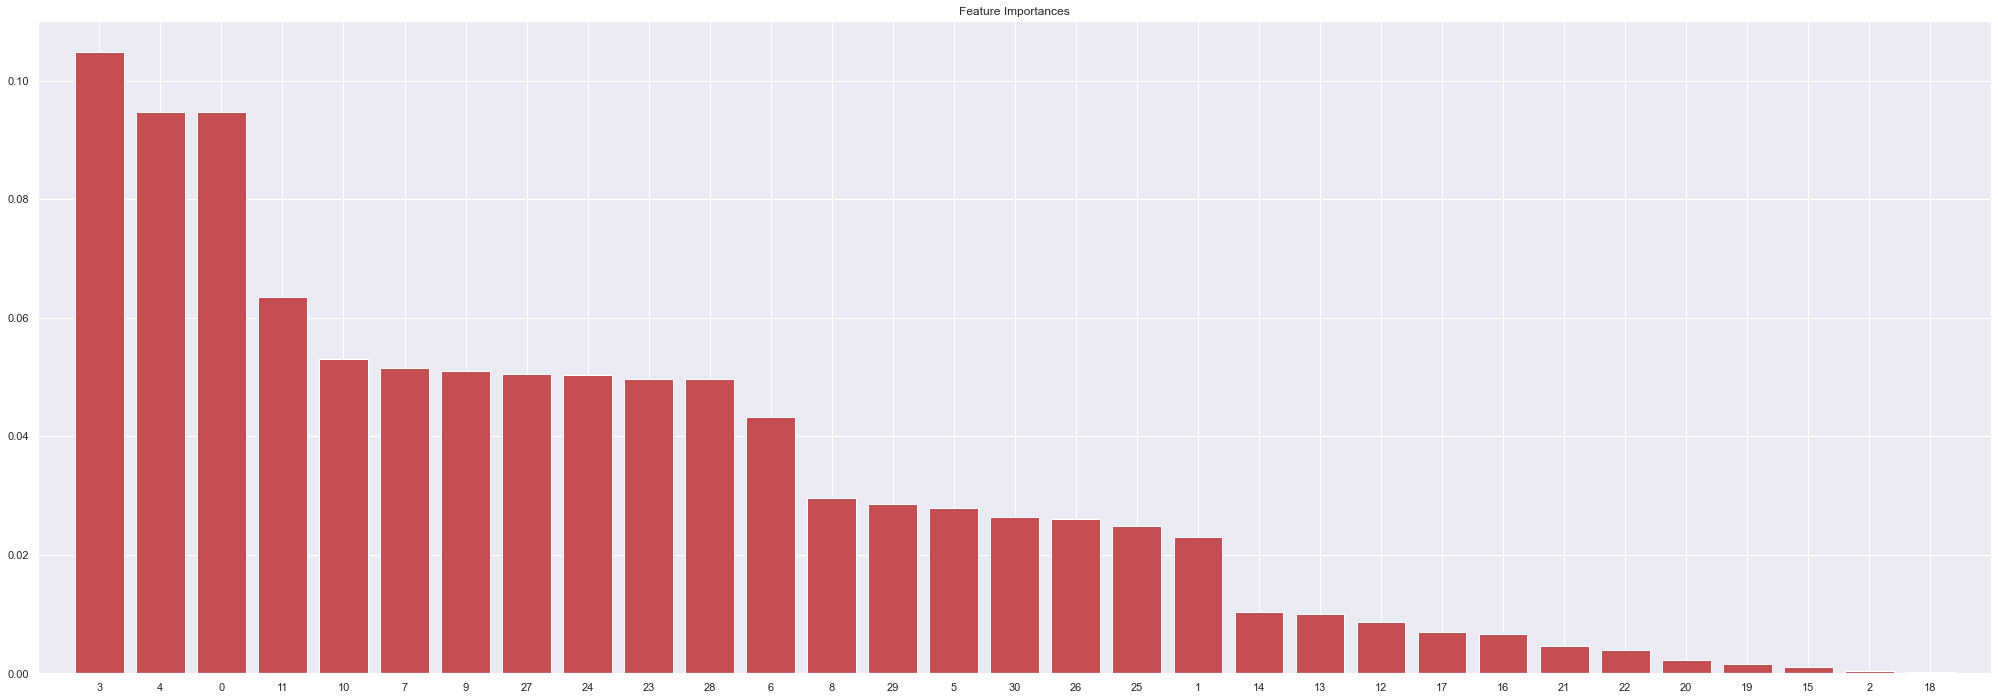

In [12]:
# plot the impurity-base feature importance of the forest
plt.figure()
plt.title('Feature Importances')
plt.bar(range(x_train_n.shape[1]), importances[indices], color='r', align='center')
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

In [13]:
# features with more than 4% importance
cols_selected_1 = df[df['importance'] >= 0.04]['feature'].values.tolist()
cols_selected_1

['age',
 'days_from_account_created_until_first_booking',
 'day_first_booking',
 'year_account_created',
 'day_account_created',
 'week_of_year_account_created',
 'affiliate_channel',
 'first_affiliate_tracked',
 'week_of_year_account_created_sin',
 'week_of_year_account_created_cos',
 'day_account_created_sin',
 'day_account_created_cos']

In [14]:
# features with more than 2% importance
cols_selected_2 = df[df['importance'] >= 0.02]['feature'].values.tolist()
cols_selected_2

['age',
 'signup_flow',
 'days_from_account_created_until_first_booking',
 'day_first_booking',
 'day_of_week_first_booking',
 'year_account_created',
 'day_account_created',
 'day_of_week_account_created',
 'week_of_year_account_created',
 'affiliate_channel',
 'first_affiliate_tracked',
 'week_of_year_account_created_sin',
 'week_of_year_account_created_cos',
 'day_of_week_first_booking_sin',
 'day_of_week_first_booking_cos',
 'day_account_created_sin',
 'day_account_created_cos',
 'day_of_week_account_created_sin',
 'day_of_week_account_created_cos']

# 11. ML Models

In [54]:
df7

,age,signup_flow,affiliate_channel,first_affiliate_tracked,country_destination,days_from_first_active_until_account_created,days_from_account_created_until_first_booking,day_first_booking,day_of_week_first_booking,year_account_created,day_account_created,day_of_week_account_created,week_of_year_account_created,gender_-unknown-,gender_FEMALE,gender_MALE,gender_OTHER,signup_method_basic,signup_method_facebook,signup_method_google,signup_app_Android,signup_app_Moweb,signup_app_Web,signup_app_iOS,country_number,week_of_year_account_created_sin,week_of_year_account_created_cos,day_of_week_first_booking_sin,day_of_week_first_booking_cos,day_account_created_sin,day_account_created_cos,day_of_week_account_created_sin,day_of_week_account_created_cos
1,0.042641,0.0,1.136346,1.120040,NDF,732.0,2.053140,29,0,0.25,25,2,21,0,0,1,0,0,1,0,0,0,1,0,0,0.568065,-8.229839e-01,0.000000,1.000000,-0.937752,0.347305,0.974928,-0.222521
2,1.333904,3.0,1.118064,1.120040,US,476.0,-0.447665,2,0,0.00,28,1,39,0,1,0,0,1,0,0,0,0,1,0,1,-1.000000,-1.836970e-16,0.000000,1.000000,-0.571268,0.820763,0.781831,0.623490
3,0.329588,0.0,1.118064,1.120040,other,765.0,0.091787,8,5,0.25,5,0,49,0,1,0,0,0,1,0,0,0,1,0,2,-0.354605,9.350162e-01,-0.974928,-0.222521,0.848644,0.528964,0.000000,1.000000
4,0.257851,0.0,1.118064,1.120040,US,280.0,-0.690821,18,3,0.00,14,1,37,1,0,0,0,1,0,0,0,0,1,0,1,-0.970942,-2.393157e-01,0.433884,-0.900969,0.299363,-0.954139,0.781831,0.623490
6,0.616536,0.0,0.787381,1.120040,US,0.0,-0.351047,5,1,0.00,2,5,53,0,1,0,0,1,0,0,0,0,1,0,1,0.120537,9.927089e-01,0.781831,0.623490,0.394356,0.918958,-0.974928,-0.222521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213441,-0.244306,0.0,1.118064,1.059009,ES,0.0,-0.285024,13,2,1.00,30,0,27,0,1,0,0,1,0,0,0,0,1,0,6,-0.120537,-9.927089e-01,0.974928,-0.222521,-0.201299,0.979530,0.000000,1.000000
213443,-0.100833,0.0,1.100411,1.059009,US,0.0,-0.334944,13,6,1.00,30,0,27,0,1,0,0,1,0,0,0,0,1,0,1,-0.120537,-9.927089e-01,-0.781831,0.623490,-0.201299,0.979530,0.000000,1.000000
213445,-1.033411,0.0,1.100411,1.021677,US,0.0,-0.352657,2,2,1.00,30,0,27,0,1,0,0,1,0,0,0,0,1,0,1,-0.120537,-9.927089e-01,0.974928,-0.222521,-0.201299,0.979530,0.000000,1.000000
213446,-0.387780,0.0,1.100411,1.021677,NDF,0.0,0.230274,29,0,1.00,30,0,27,0,0,1,0,1,0,0,0,0,1,0,0,-0.120537,-9.927089e-01,0.000000,1.000000,-0.201299,0.979530,0.000000,1.000000


In [15]:
# ================ balanced ==========================

df11 = df10[cols_selected_1 + ['country_destination']].copy()

X = df11.drop('country_destination', axis=1)
y = df11['country_destination'].copy()

X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=32)


# ========= imbalanced ======================

df_imb = df7[cols_selected_1 + ['country_destination']].copy()

X = df_imb.drop(['country_destination'], axis=1)
y = df_imb['country_destination'].copy()

X_train_imb, X_test_imb, y_train_imb, y_test_imb = ms.train_test_split(X, y, test_size=0.2, random_state=32)

In [47]:
X_train

,age,days_from_account_created_until_first_booking,day_first_booking,year_account_created,day_account_created,week_of_year_account_created,affiliate_channel,first_affiliate_tracked,week_of_year_account_created_sin,week_of_year_account_created_cos,day_account_created_sin,day_account_created_cos
537139,-0.590742,0.160920,29,1.00,9,23,5.512895,5.615767,0.354605,-9.350162e-01,0.968077,-0.250653
637199,-0.438603,-0.057471,13,0.50,13,33,5.671073,5.615767,-0.748511,-6.631227e-01,0.485302,-0.874347
636256,-0.666811,-0.057471,8,0.50,8,23,5.411566,5.367575,0.354605,-9.350162e-01,0.998717,-0.050649
292791,-0.514672,-0.057471,13,0.75,13,11,5.512895,5.538512,0.970942,2.393157e-01,0.485302,-0.874347
68643,0.702441,-0.057471,9,0.75,9,41,4.377661,5.538512,-0.970942,2.393157e-01,0.968077,-0.250653
...,...,...,...,...,...,...,...,...,...,...,...,...
282558,-0.286464,-0.045977,30,0.75,28,13,5.824866,5.367575,1.000000,6.123234e-17,-0.571268,0.820763
599350,-0.438603,-0.045977,13,0.50,11,46,5.512895,5.538512,-0.663123,7.485107e-01,0.790776,-0.612106
655237,-0.514672,-0.034483,11,0.25,9,36,5.512895,5.538512,-0.935016,-3.546049e-01,0.968077,-0.250653
370219,1.006719,-0.022989,16,0.50,13,15,5.512895,5.538512,0.970942,-2.393157e-01,0.485302,-0.874347


## 6.1. Baseline Model

***random*** — Generate pseudo-random numbers:

random.choices(population, weights=None, *, cum_weights=None, k=1)
***Return a k sized list of elements chosen from the population with replacement***. If the population is empty, raises IndexError.

***If a weights sequence is specified, selections are made according to the relative weights***. Alternatively, if a cum_weights sequence is given, the selections are made according to the cumulative weights (perhaps computed using itertools.accumulate()). For example, the relative weights [10, 5, 30, 5] are equivalent to the cumulative weights [10, 15, 45, 50]. Internally, the relative weights are converted to cumulative weights before making selections, so supplying the cumulative weights saves work.

***If neither weights nor cum_weights are specified, selections are made with equal probability***. If a weights sequence is supplied, it must be the same length as the population sequence. It is a TypeError to specify both weights and cum_weights.

The weights or cum_weights can use any numeric type that interoperates with the float values returned by random() (that includes integers, floats, and fractions but excludes decimals). Behavior is undefined if any weight is negative. A ValueError is raised if all weights are zero.

For a given seed, the choices() function with equal weighting typically produces a different sequence than repeated calls to choice(). The algorithm used by choices() uses floating point arithmetic for internal consistency and speed. The algorithm used by choice() defaults to integer arithmetic with repeated selections to avoid small biases from round-off error.

In [178]:
# population list
country_destination_list = df1['country_destination'].drop_duplicates().sort_values().tolist()
# list of weights in the same order as population
country_destination_weights = df1['country_destination'].value_counts(normalize=True).sort_index().tolist()
# size of the list generated
k_num = y_test.shape[0]

yhat_random = random.choices(population = country_destination_list, weights=country_destination_weights, k=k_num)

Accuracy: 0.3610159817351598
Balanced Accuracy: 0.08360302410029193
Kappa Score: 0.001987976944519576
              precision    recall  f1-score   support

          AU       0.01      0.01      0.01        87
          CA       0.01      0.01      0.01       216
          DE       0.01      0.01      0.01       164
          ES       0.00      0.00      0.00       319
          FR       0.03      0.02      0.03       736
          GB       0.01      0.01      0.01       361
          IT       0.03      0.02      0.02       420
         NDF       0.45      0.45      0.45     10962
          NL       0.00      0.00      0.00       105
          PT       0.00      0.00      0.00        31
          US       0.39      0.39      0.39      9606
       other       0.07      0.07      0.07      1521

    accuracy                           0.36     24528
   macro avg       0.08      0.08      0.08     24528
weighted avg       0.36      0.36      0.36     24528



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

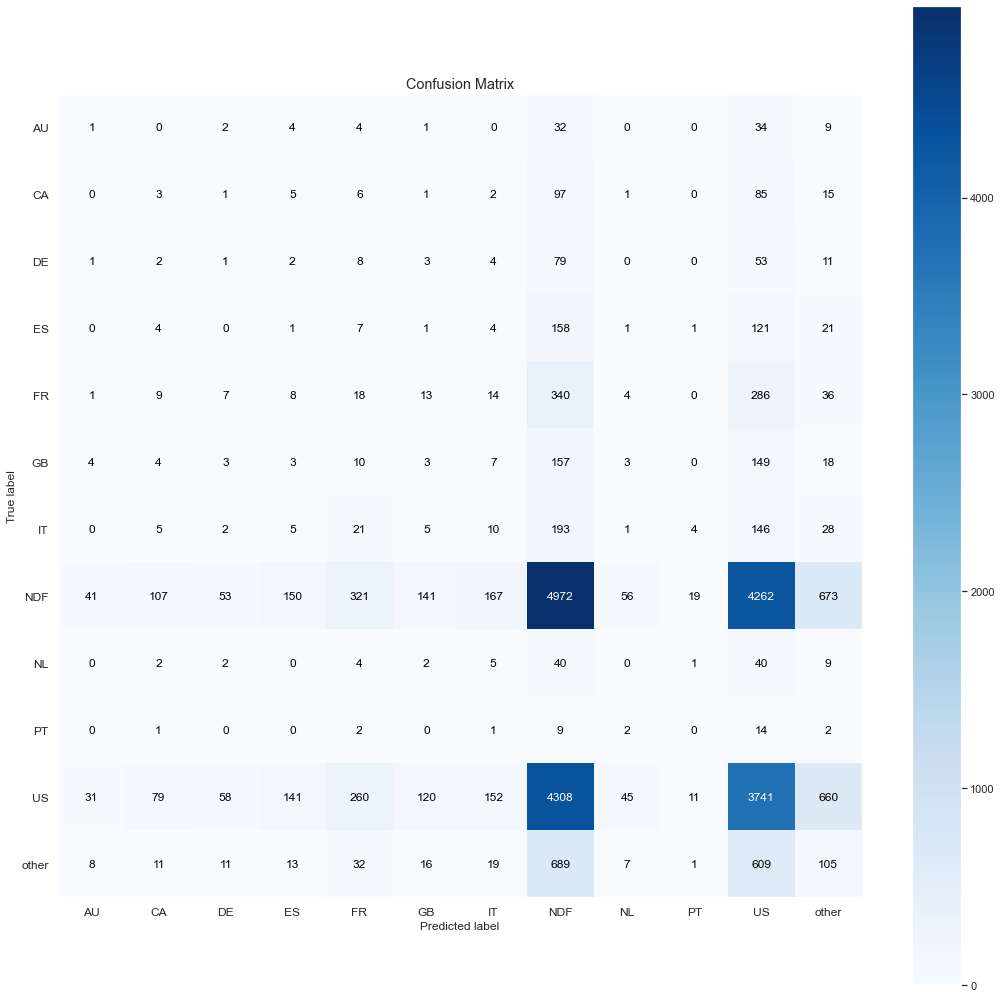

In [179]:
# BASELINE MODEL PERFORMANCE
acc_random = m.accuracy_score(y_test, yhat_random)
balance_acc_random = m.balanced_accuracy_score(y_test, yhat_random)
kappa_random = m.cohen_kappa_score(y_test, yhat_random)

# print
print('Accuracy: {}'.format(acc_random))
print('Balanced Accuracy: {}'.format(balance_acc_random))
print('Kappa Score: {}'.format(kappa_random))
print(m.classification_report(y_test, yhat_random))

# confusion matrix
mt.plot_confusion_matrix(y_test, yhat_random, normalize=False, figsize=(18,18))

## 6.2. Neural Network - cols_seleted_1 (best feature selection)

In [106]:
ohe = pp.OneHotEncoder()

y_train_nn = ohe.fit_transform(y_train.values.reshape(-1,1)).toarray()
y_train_nn

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [107]:
y_train_nn.shape

(526448, 12)

In [108]:
X_train.shape

(526448, 31)

In [109]:
# model definition
model = ml.Sequential()
model.add(l.Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(l.Dense(12, activation='softmax'))

# model compile
model.compile( loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'] )

# train model
model.fit(X_train, y_train_nn, epochs=50)

Epoch 1/50
16452/16452 [==============================] - 37s 2ms/step - loss: 2.0339 - accuracy: 0.2870
Epoch 2/50
16452/16452 [==============================] - 37s 2ms/step - loss: 1.8438 - accuracy: 0.3595
Epoch 3/50
16452/16452 [==============================] - 45s 3ms/step - loss: 1.7611 - accuracy: 0.3900
Epoch 4/50
16452/16452 [==============================] - 50s 3ms/step - loss: 1.7179 - accuracy: 0.4054
Epoch 5/50
16452/16452 [==============================] - 51s 3ms/step - loss: 1.6898 - accuracy: 0.4148
Epoch 6/50
16452/16452 [==============================] - 40s 2ms/step - loss: 1.6714 - accuracy: 0.4208
Epoch 7/50
16452/16452 [==============================] - 39s 2ms/step - loss: 1.6583 - accuracy: 0.4251
Epoch 8/50
16452/16452 [==============================] - 43s 3ms/step - loss: 1.6479 - accuracy: 0.4286
Epoch 9/50
16452/16452 [==============================] - 43s 3ms/step - loss: 1.6388 - accuracy: 0.4316
Epoch 10/50
16452/16452 [==============================

## Performance for balanced test_set

In [113]:
# prediction
pred_nn = model.predict(X_test)

# invert prediction
yhat_nn = ohe.inverse_transform(pred_nn)

# prediction prepare
y_test_nn = y_test
yhat_nn = yhat_nn.reshape(1,-1)[0]

Accuracy: 0.4639394584080479
Balanced Accuracy: 0.46390875655315966
Kappa Score: 0.4152062471352278
              precision    recall  f1-score   support

          AU       0.46      0.82      0.59     11015
          CA       0.33      0.23      0.27     10996
          DE       0.28      0.57      0.37     10994
          ES       0.24      0.22      0.23     10957
          FR       0.25      0.05      0.08     10971
          GB       0.24      0.11      0.15     10994
          IT       0.26      0.13      0.18     10922
         NDF       1.00      1.00      1.00     10993
          NL       0.44      0.54      0.49     10870
          PT       0.78      0.98      0.87     10981
          US       0.53      0.81      0.64     10919
       other       0.26      0.12      0.16     11000

    accuracy                           0.46    131612
   macro avg       0.42      0.46      0.42    131612
weighted avg       0.42      0.46      0.42    131612



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

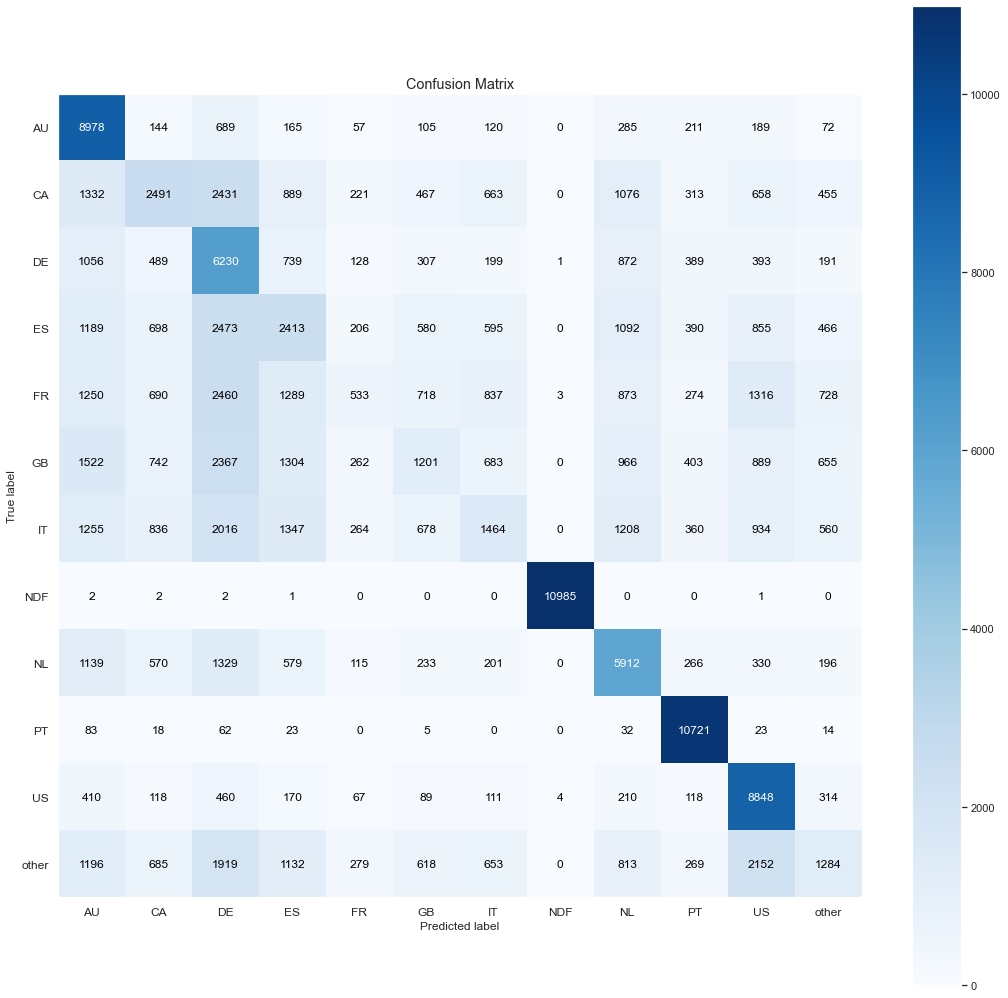

In [114]:
# scores
acc_nn = m.accuracy_score(y_test_nn, yhat_nn)
balance_acc_nn = m.balanced_accuracy_score(y_test, yhat_nn)
kappa_nn = m.cohen_kappa_score(y_test, yhat_nn)

# print
print('Accuracy: {}'.format(acc_nn))
print('Balanced Accuracy: {}'.format(balance_acc_nn))
print('Kappa Score: {}'.format(kappa_nn))
print(m.classification_report(y_test, yhat_nn))

# confusion matrix
mt.plot_confusion_matrix(y_test_nn, yhat_nn, normalize=False, figsize=(18,18)) 

## Performance for imbalanced test_set

In [119]:
# prediction
pred_nn = model.predict(X_test_imb)

# invert prediction
yhat_nn = ohe.inverse_transform(pred_nn)

# prediction prepare
y_test_nn = y_test_imb.to_numpy()
yhat_nn = yhat_nn.reshape(1,-1)[0]

Accuracy: 0.8017367906066536
Balanced Accuracy: 0.25677839228248145
Kappa Score: 0.6730887101443572
              precision    recall  f1-score   support

          AU       0.06      0.26      0.10        87
          CA       0.11      0.02      0.03       216
          DE       0.04      0.09      0.05       164
          ES       0.13      0.03      0.05       319
          FR       0.24      0.01      0.01       736
          GB       0.07      0.01      0.01       361
          IT       0.04      0.01      0.01       420
         NDF       1.00      1.00      1.00     10962
          NL       0.08      0.13      0.10       105
          PT       0.15      0.61      0.24        31
          US       0.71      0.89      0.79      9606
       other       0.13      0.01      0.02      1521

    accuracy                           0.80     24528
   macro avg       0.23      0.26      0.20     24528
weighted avg       0.75      0.80      0.76     24528



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

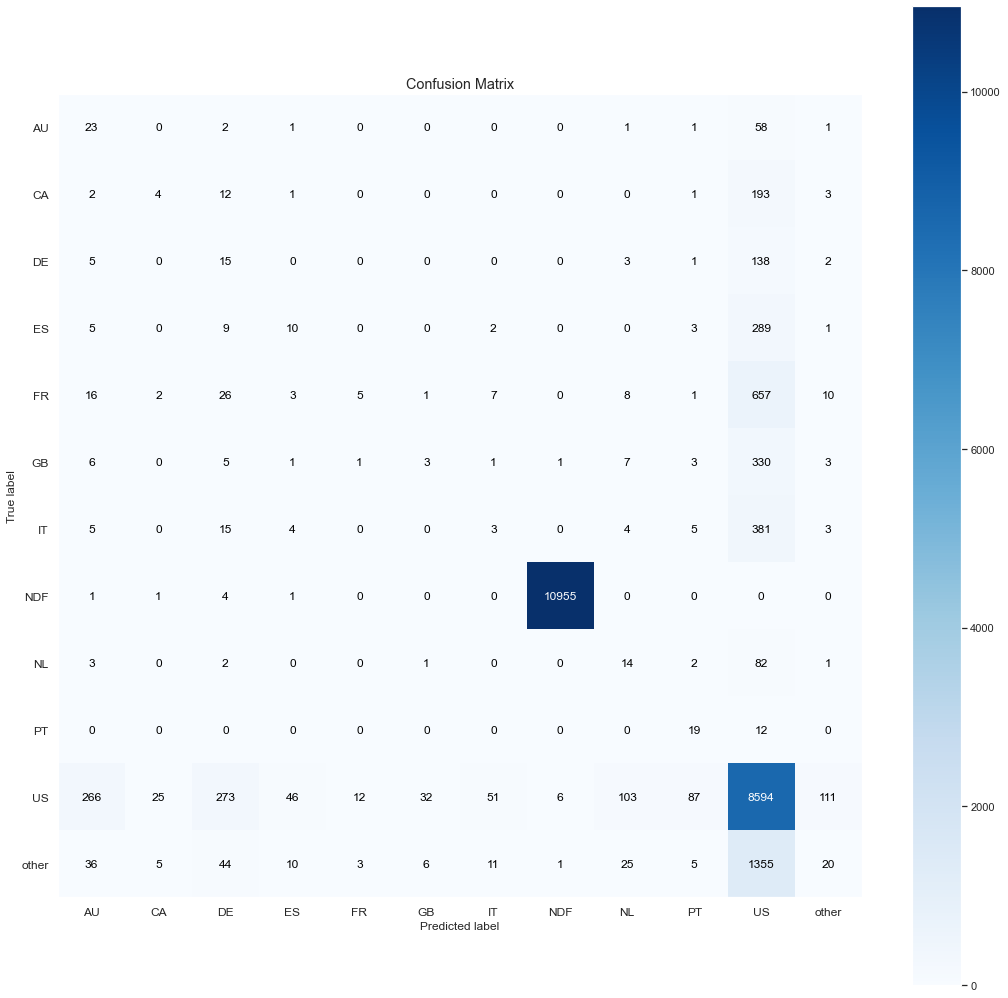

In [120]:
# scores
acc_nn = m.accuracy_score(y_test_nn, yhat_nn)
balance_acc_nn = m.balanced_accuracy_score(y_test_imb, yhat_nn)
kappa_nn = m.cohen_kappa_score(y_test_imb, yhat_nn)

# print
print('Accuracy: {}'.format(acc_nn))
print('Balanced Accuracy: {}'.format(balance_acc_nn))
print('Kappa Score: {}'.format(kappa_nn))
print(m.classification_report(y_test_imb, yhat_nn))

# confusion matrix
mt.plot_confusion_matrix(y_test_nn, yhat_nn, normalize=False, figsize=(18,18)) 

## 6.3. Neural Network - cols_selected_2

In [125]:
df12 = df10[cols_selected_2 + ['country_destination']].copy()

X = df12.drop('country_destination', axis=1)
y = df12['country_destination'].copy()

X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=32)

In [126]:
ohe = pp.OneHotEncoder()

y_train_nn = ohe.fit_transform(y_train.values.reshape(-1,1)).toarray()
y_train_nn

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [127]:
# model definition
model = ml.Sequential()
model.add(l.Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(l.Dense(12, activation='softmax'))

# model compile
model.compile( loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'] )

# train model
model.fit(X_train, y_train_nn, epochs=50)

Epoch 1/50
16452/16452 [==============================] - 42s 3ms/step - loss: 2.0901 - accuracy: 0.2555
Epoch 2/50
16452/16452 [==============================] - 37s 2ms/step - loss: 1.9137 - accuracy: 0.3247
Epoch 3/50
16452/16452 [==============================] - 28s 2ms/step - loss: 1.8414 - accuracy: 0.3507
Epoch 4/50
16452/16452 [==============================] - 29s 2ms/step - loss: 1.8007 - accuracy: 0.3659
Epoch 5/50
16452/16452 [==============================] - 32s 2ms/step - loss: 1.7730 - accuracy: 0.3756
Epoch 6/50
16452/16452 [==============================] - 35s 2ms/step - loss: 1.7558 - accuracy: 0.3826
Epoch 7/50
16452/16452 [==============================] - 38s 2ms/step - loss: 1.7423 - accuracy: 0.3868
Epoch 8/50
16452/16452 [==============================] - 34s 2ms/step - loss: 1.7313 - accuracy: 0.3903
Epoch 9/50
16452/16452 [==============================] - 31s 2ms/step - loss: 1.7226 - accuracy: 0.3934
Epoch 10/50
16452/16452 [==============================

## Performance for balanced test_set

In [128]:
# prediction
pred_nn = model.predict(X_test)

# invert prediction
yhat_nn = ohe.inverse_transform(pred_nn)

# prediction prepare
y_test_nn = y_test
yhat_nn = yhat_nn.reshape(1,-1)[0]

Accuracy: 0.43216424034282586
Balanced Accuracy: 0.432120820122212
Kappa Score: 0.3805619866164467
              precision    recall  f1-score   support

          AU       0.49      0.71      0.58     11015
          CA       0.26      0.35      0.30     10996
          DE       0.31      0.40      0.35     10994
          ES       0.24      0.17      0.20     10957
          FR       0.22      0.10      0.14     10971
          GB       0.27      0.05      0.08     10994
          IT       0.25      0.10      0.14     10922
         NDF       1.00      1.00      1.00     10993
          NL       0.39      0.46      0.42     10870
          PT       0.76      0.90      0.83     10981
          US       0.36      0.82      0.50     10919
       other       0.23      0.13      0.16     11000

    accuracy                           0.43    131612
   macro avg       0.40      0.43      0.39    131612
weighted avg       0.40      0.43      0.39    131612



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

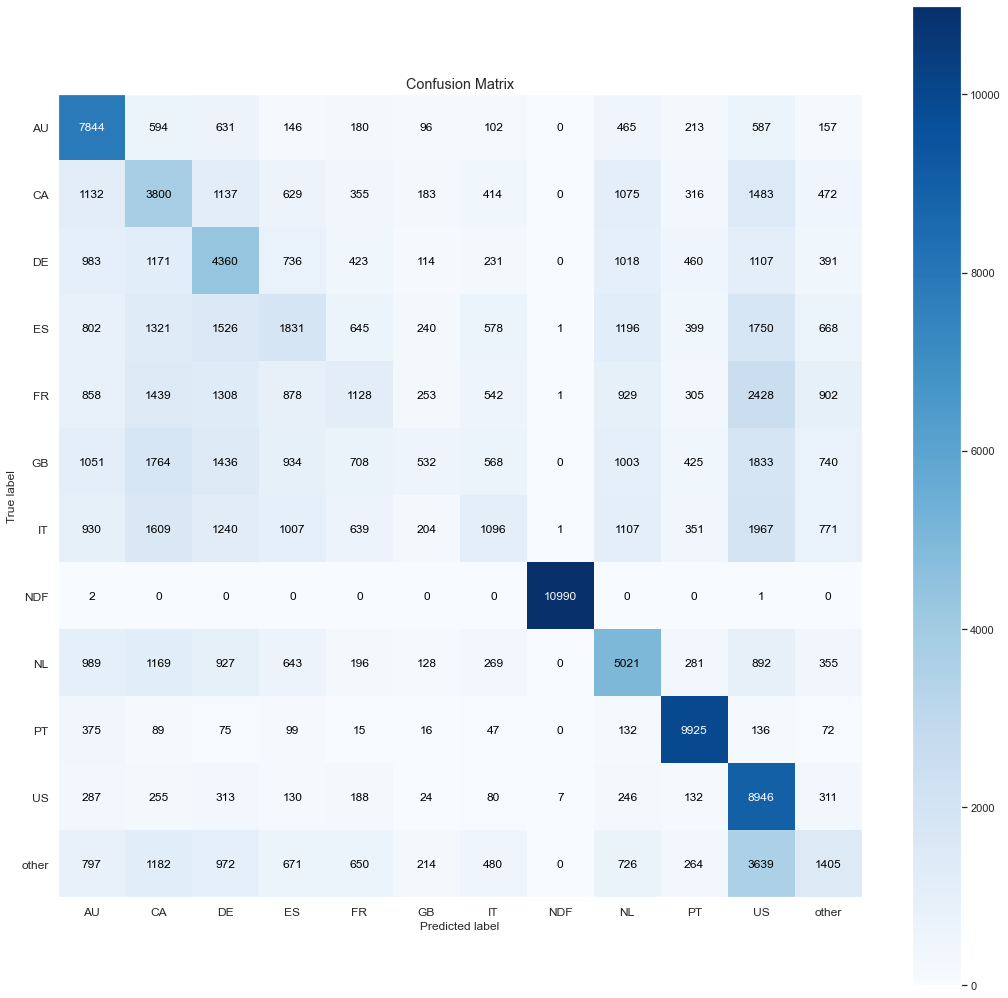

In [129]:
# scores
acc_nn = m.accuracy_score(y_test_nn, yhat_nn)
balance_acc_nn = m.balanced_accuracy_score(y_test, yhat_nn)
kappa_nn = m.cohen_kappa_score(y_test, yhat_nn)

# print
print('Accuracy: {}'.format(acc_nn))
print('Balanced Accuracy: {}'.format(balance_acc_nn))
print('Kappa Score: {}'.format(kappa_nn))
print(m.classification_report(y_test, yhat_nn))

# confusion matrix
mt.plot_confusion_matrix(y_test_nn, yhat_nn, normalize=False, figsize=(18,18)) 

# Tree based methods - XGBoost, Random Forest, CatBoost

## XGBoost Classifier

c:\users\lucas\miniconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.6099212023487176
Balanced Accuracy: 0.6097199898326535
Kappa Score: 0.5744518694665722
              precision    recall  f1-score   support

          AU       0.61      0.82      0.70     11001
          CA       0.56      0.63      0.59     10969
          DE       0.59      0.68      0.63     11062
          ES       0.54      0.53      0.54     11002
          FR       0.53      0.37      0.44     10874
          GB       0.59      0.47      0.52     10911
          IT       0.55      0.46      0.50     10861
         NDF       1.00      1.00      1.00     10982
          NL       0.61      0.74      0.67     10720
          PT       0.69      0.94      0.80     11065
          US       0.44      0.43      0.43     10949
       other       0.48      0.25      0.33     11080

    accuracy                           0.61    131476
   macro avg       0.60      0.61      0.60    131476
weighted avg       0.60      0.61      0.60    131476



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

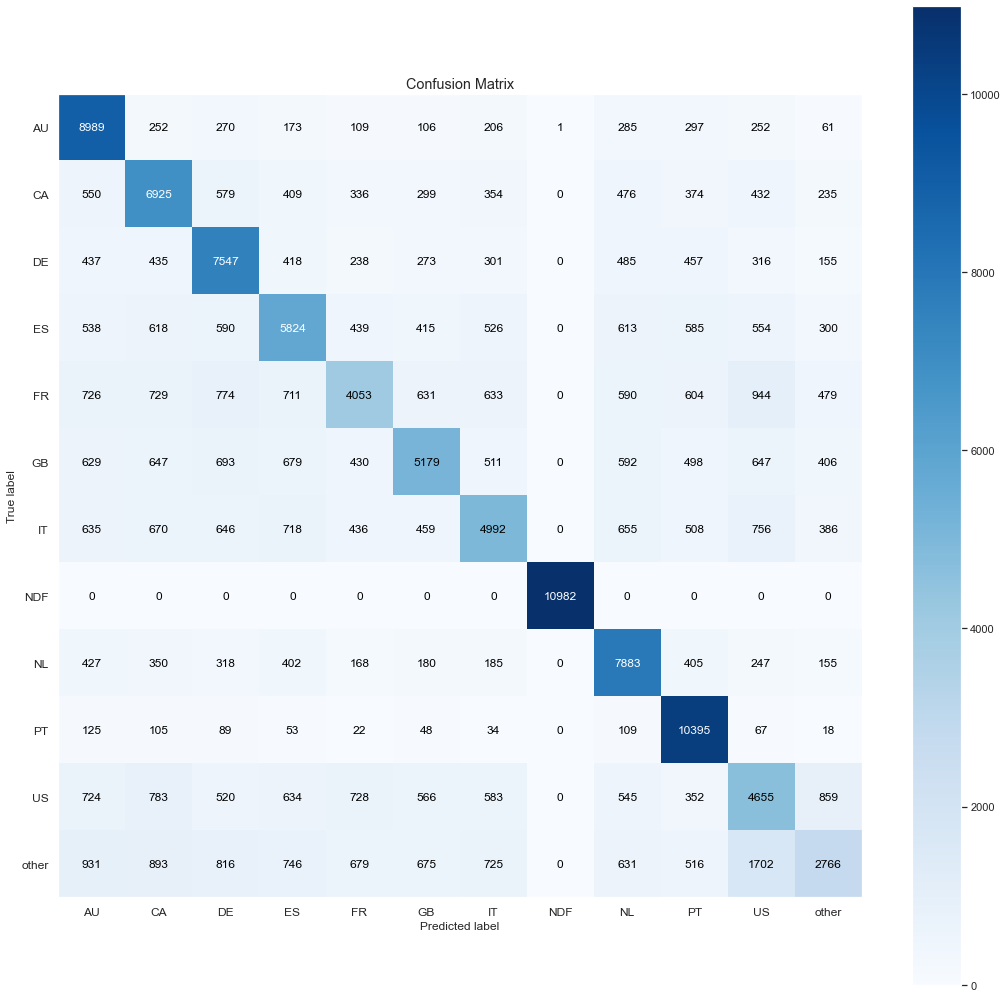

In [66]:
## XGBoost
# model definition
xgb_model = XGBClassifier()

# model training
xgb_model.fit(X_train, y_train)

# predict
yhat = xgb_model.predict(X_test)

# scores
# scores
acc_nn = m.accuracy_score(y_test, yhat)
balance_acc_nn = m.balanced_accuracy_score(y_test, yhat)
kappa_nn = m.cohen_kappa_score(y_test, yhat)

# print
print('Accuracy: {}'.format(acc_nn))
print('Balanced Accuracy: {}'.format(balance_acc_nn))
print('Kappa Score: {}'.format(kappa_nn))
print(m.classification_report(y_test, yhat))

# confusion matrix
mt.plot_confusion_matrix(y_test, yhat, normalize=False, figsize=(18,18))

Accuracy: 0.19275929549902152
Balanced Accuracy: 0.13032124399985934
Kappa Score: -0.05013173417280736


c:\users\lucas\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          AU       0.01      0.08      0.02        87
          CA       0.05      0.05      0.05       216
          DE       0.03      0.12      0.05       164
          ES       0.04      0.03      0.03       319
          FR       0.02      0.03      0.02       736
          GB       0.05      0.20      0.08       361
          IT       0.04      0.25      0.06       420
         NDF       0.00      0.00      0.00     10962
          NL       0.03      0.06      0.04       105
          PT       0.03      0.10      0.05        31
          US       0.30      0.43      0.35      9606
       other       0.10      0.24      0.14      1521

    accuracy                           0.19     24528
   macro avg       0.06      0.13      0.07     24528
weighted avg       0.13      0.19      0.15     24528



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

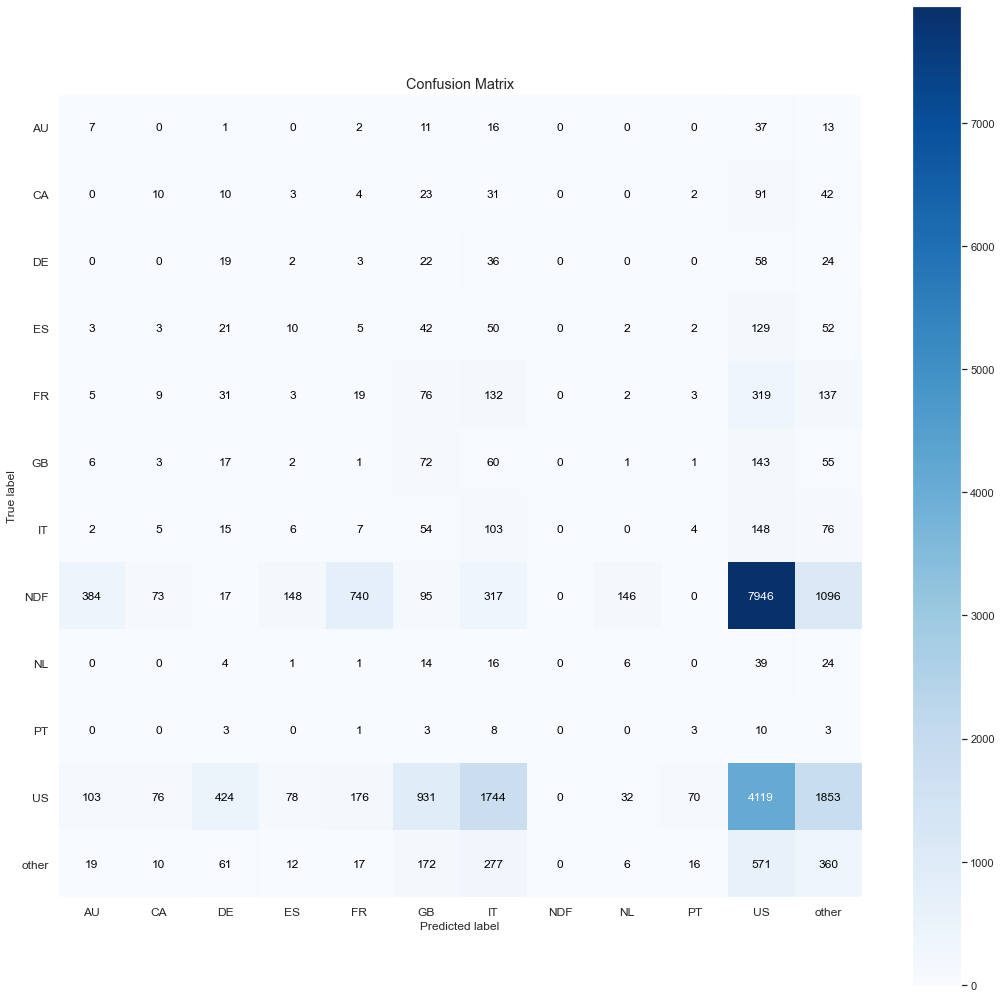

In [67]:
## XGBoost
# model definition
xgb_model = XGBClassifier()

# model training
xgb_model.fit(X_train, y_train)

# predict
yhat = xgb_model.predict(X_test_imb)

# scores
# scores
acc_nn = m.accuracy_score(y_test_imb, yhat)
balance_acc_nn = m.balanced_accuracy_score(y_test_imb, yhat)
kappa_nn = m.cohen_kappa_score(y_test_imb, yhat)

# print
print('Accuracy: {}'.format(acc_nn))
print('Balanced Accuracy: {}'.format(balance_acc_nn))
print('Kappa Score: {}'.format(kappa_nn))
print(m.classification_report(y_test_imb, yhat))

# confusion matrix
mt.plot_confusion_matrix(y_test_imb, yhat, normalize=False, figsize=(18,18))

## Random Forest Classifier

Accuracy: 0.9147829261614288
Balanced Accuracy: 0.9148190850063385
Kappa Score: 0.9070357043334996
              precision    recall  f1-score   support

          AU       0.96      0.99      0.97     11001
          CA       0.92      0.96      0.94     10969
          DE       0.94      0.97      0.96     11062
          ES       0.91      0.94      0.92     11002
          FR       0.87      0.89      0.88     10874
          GB       0.91      0.94      0.92     10911
          IT       0.90      0.92      0.91     10861
         NDF       1.00      1.00      1.00     10982
          NL       0.95      0.98      0.96     10720
          PT       0.98      0.99      0.99     11065
          US       0.78      0.60      0.68     10949
       other       0.83      0.80      0.82     11080

    accuracy                           0.91    131476
   macro avg       0.91      0.91      0.91    131476
weighted avg       0.91      0.91      0.91    131476



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

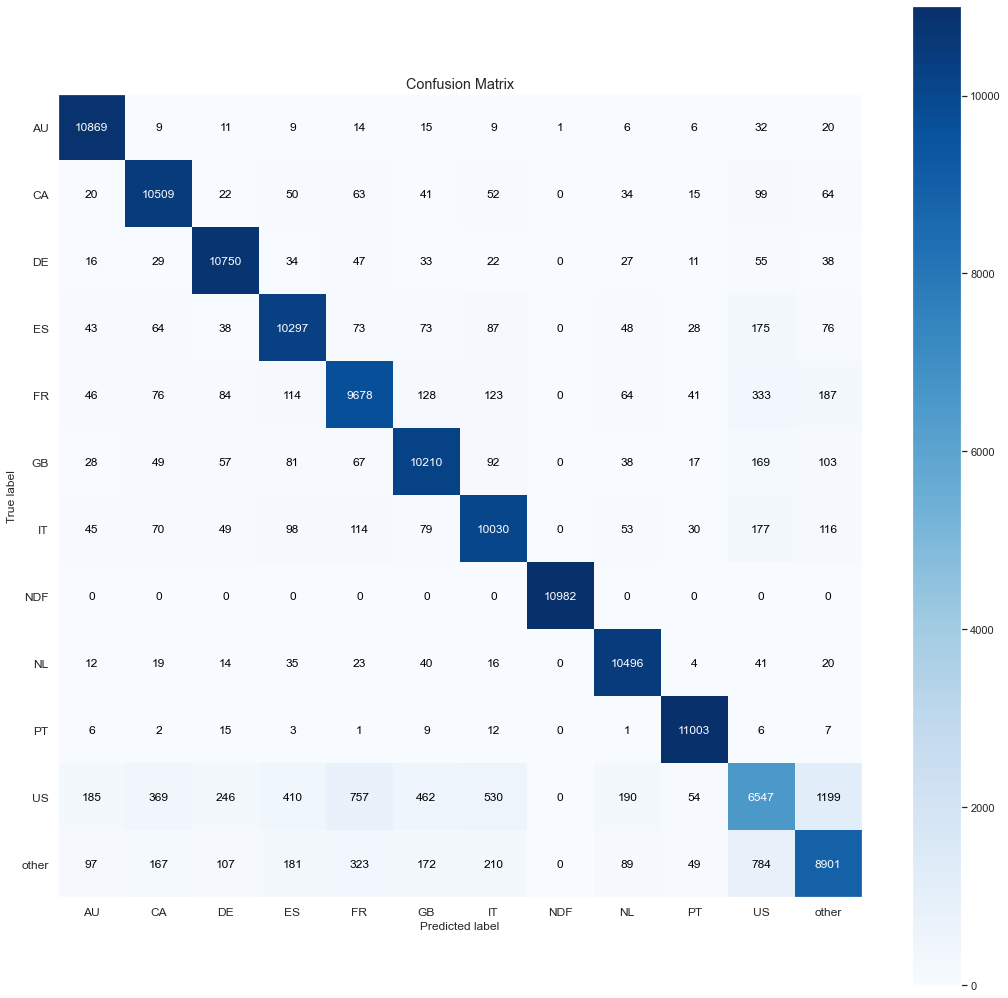

In [16]:
## Random Forest
# model definition
rf_model = en.RandomForestClassifier()

# model training
rf_model.fit(X_train, y_train)

# predict
yhat = rf_model.predict(X_test)

# scores
acc_nn = m.accuracy_score(y_test, yhat)
balance_acc_nn = m.balanced_accuracy_score(y_test, yhat)
kappa_nn = m.cohen_kappa_score(y_test, yhat)

# print
print('Accuracy: {}'.format(acc_nn))
print('Balanced Accuracy: {}'.format(balance_acc_nn))
print('Kappa Score: {}'.format(kappa_nn))
print(m.classification_report(y_test, yhat))

# confusion matrix
mt.plot_confusion_matrix(y_test, yhat, normalize=False, figsize=(18,18)) 

Accuracy: 0.3323956294846706
Balanced Accuracy: 0.14601749985818804
Kappa Score: -0.0009829843011008865


c:\users\lucas\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          AU       0.03      0.07      0.04        87
          CA       0.06      0.12      0.08       216
          DE       0.06      0.07      0.06       164
          ES       0.10      0.12      0.11       319
          FR       0.13      0.11      0.12       736
          GB       0.13      0.10      0.11       361
          IT       0.11      0.09      0.10       420
         NDF       0.00      0.00      0.00     10962
          NL       0.04      0.08      0.05       105
          PT       0.03      0.06      0.04        31
          US       0.38      0.80      0.51      9606
       other       0.15      0.13      0.14      1521

    accuracy                           0.33     24528
   macro avg       0.10      0.15      0.11     24528
weighted avg       0.17      0.33      0.22     24528



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

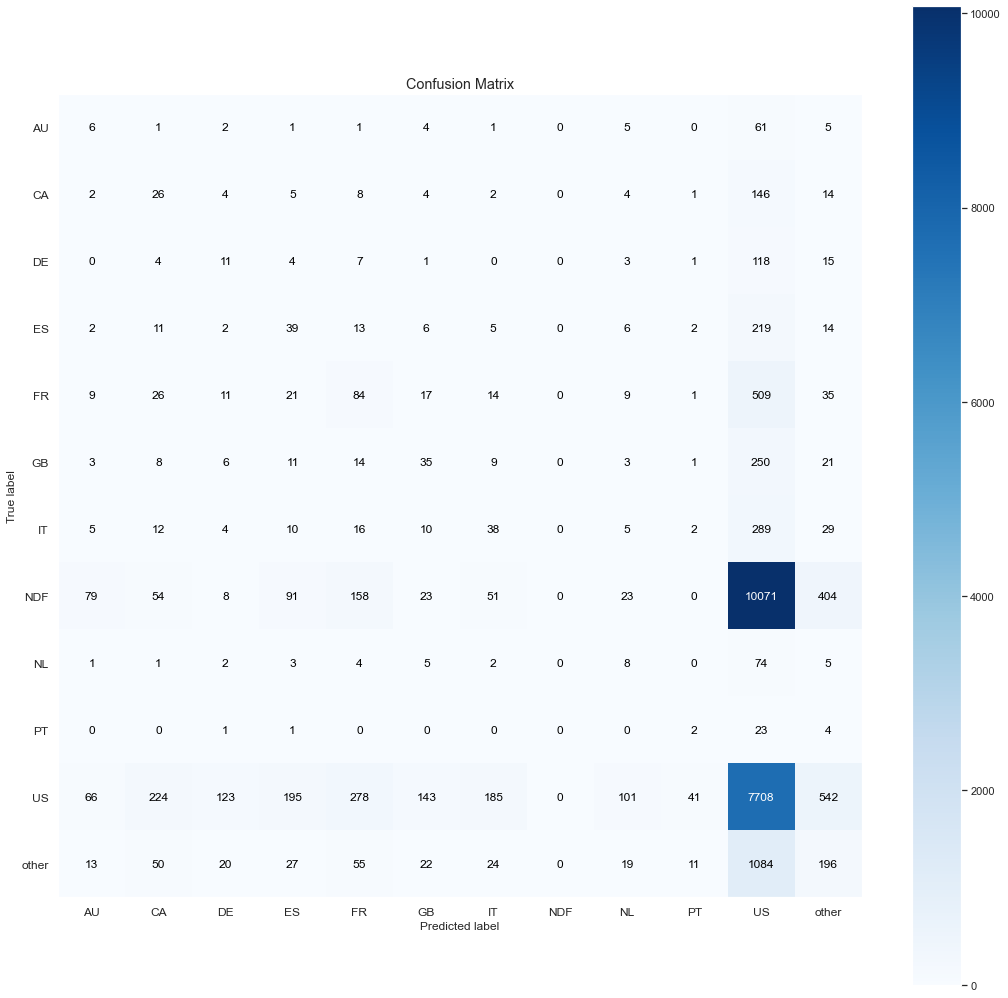

In [17]:
# predict
yhat = rf_model.predict(X_test_imb)

# scores
acc_nn = m.accuracy_score(y_test_imb, yhat)
balance_acc_nn = m.balanced_accuracy_score(y_test_imb, yhat)
kappa_nn = m.cohen_kappa_score(y_test_imb, yhat)

# print
print('Accuracy: {}'.format(acc_nn))
print('Balanced Accuracy: {}'.format(balance_acc_nn))
print('Kappa Score: {}'.format(kappa_nn))
print(m.classification_report(y_test_imb, yhat))

# confusion matrix
mt.plot_confusion_matrix(y_test_imb, yhat, normalize=False, figsize=(18,18)) 

Accuracy: 0.8247309197651663
Balanced Accuracy: 0.16691211344018506
Kappa Score: 0.7036426617886896
              precision    recall  f1-score   support

          AU       0.00      0.00      0.00        87
          CA       0.00      0.00      0.00       216
          DE       0.07      0.01      0.01       164
          ES       0.03      0.00      0.01       319
          FR       0.06      0.01      0.01       736
          GB       0.06      0.01      0.01       361
          IT       0.00      0.00      0.00       420
         NDF       1.00      1.00      1.00     10962
          NL       0.00      0.00      0.00       105
          PT       0.00      0.00      0.00        31
          US       0.71      0.96      0.82      9606
       other       0.11      0.02      0.03      1521

    accuracy                           0.82     24528
   macro avg       0.17      0.17      0.16     24528
weighted avg       0.74      0.82      0.77     24528



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

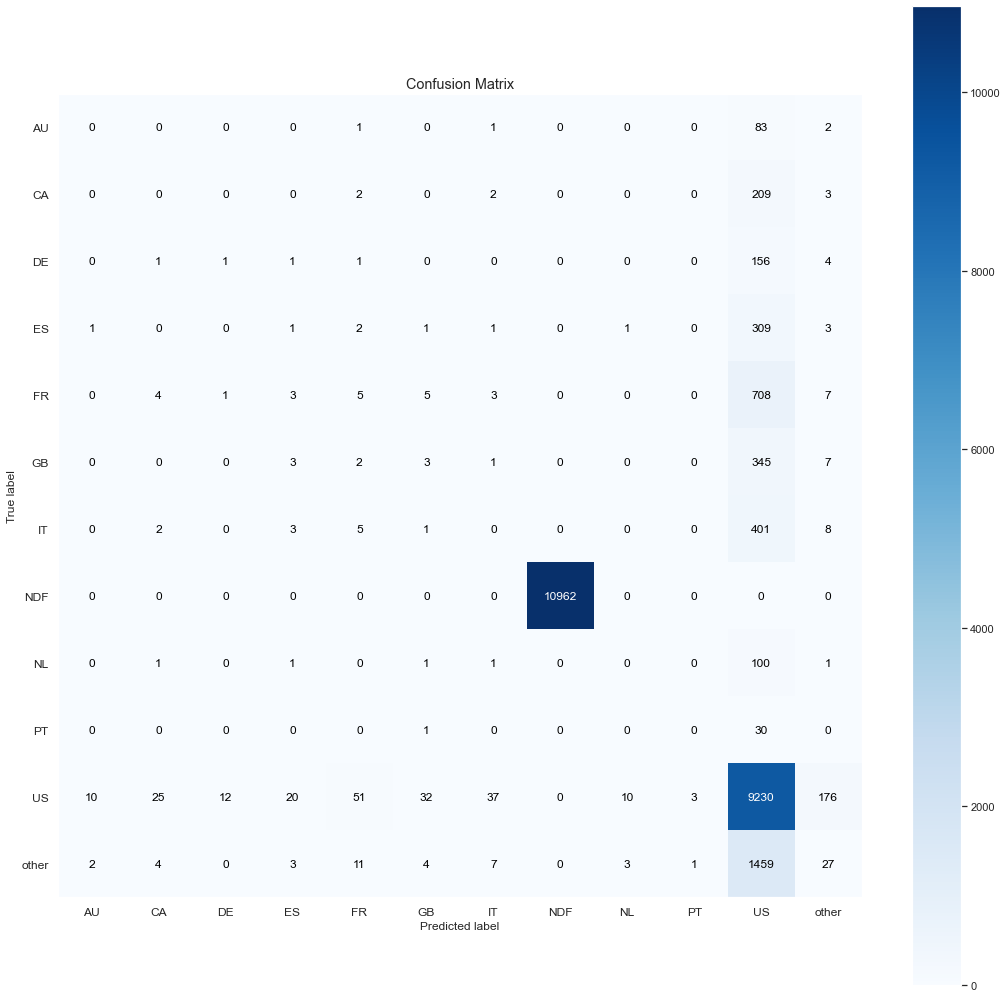

In [18]:
## Random Forest
# model definition
rf_model = en.RandomForestClassifier()

# model training
rf_model.fit(X_train_imb, y_train_imb)

# predict
yhat = rf_model.predict(X_test_imb)

# scores
acc_nn = m.accuracy_score(y_test_imb, yhat)
balance_acc_nn = m.balanced_accuracy_score(y_test_imb, yhat)
kappa_nn = m.cohen_kappa_score(y_test_imb, yhat)

# print
print('Accuracy: {}'.format(acc_nn))
print('Balanced Accuracy: {}'.format(balance_acc_nn))
print('Kappa Score: {}'.format(kappa_nn))
print(m.classification_report(y_test_imb, yhat))

# confusion matrix
mt.plot_confusion_matrix(y_test_imb, yhat, normalize=False, figsize=(18,18)) 

## CatBoost Classifier

Learning rate set to 0.108915
0:	learn: 2.3795380	total: 2.87s	remaining: 47m 44s
1:	learn: 2.3406264	total: 5.38s	remaining: 44m 45s
2:	learn: 2.3093210	total: 7.78s	remaining: 43m 6s
3:	learn: 2.2862861	total: 10.5s	remaining: 43m 29s
4:	learn: 2.2653667	total: 13.2s	remaining: 43m 46s
5:	learn: 2.2495953	total: 15.8s	remaining: 43m 44s
6:	learn: 2.2343173	total: 18.4s	remaining: 43m 25s
7:	learn: 2.2198885	total: 20.8s	remaining: 43m 1s
8:	learn: 2.2073682	total: 23.2s	remaining: 42m 33s
9:	learn: 2.1966202	total: 25.7s	remaining: 42m 22s
10:	learn: 2.1867975	total: 28.2s	remaining: 42m 19s
11:	learn: 2.1787248	total: 30.9s	remaining: 42m 22s
12:	learn: 2.1712848	total: 33.6s	remaining: 42m 27s
13:	learn: 2.1629668	total: 36.3s	remaining: 42m 39s
14:	learn: 2.1560855	total: 38.9s	remaining: 42m 31s
15:	learn: 2.1493312	total: 41.3s	remaining: 42m 18s
16:	learn: 2.1424417	total: 43.9s	remaining: 42m 16s
17:	learn: 2.1375545	total: 46.4s	remaining: 42m 12s
18:	learn: 2.1321662	total: 

152:	learn: 1.8003728	total: 8m 50s	remaining: 48m 54s
153:	learn: 1.7994899	total: 8m 54s	remaining: 48m 53s
154:	learn: 1.7979087	total: 8m 58s	remaining: 48m 53s
155:	learn: 1.7967372	total: 9m 1s	remaining: 48m 51s
156:	learn: 1.7954241	total: 9m 6s	remaining: 48m 56s
157:	learn: 1.7943128	total: 9m 10s	remaining: 48m 55s
158:	learn: 1.7927679	total: 9m 14s	remaining: 48m 54s
159:	learn: 1.7912308	total: 9m 19s	remaining: 48m 55s
160:	learn: 1.7898401	total: 9m 23s	remaining: 48m 59s
161:	learn: 1.7882960	total: 9m 27s	remaining: 48m 57s
162:	learn: 1.7867939	total: 9m 31s	remaining: 48m 53s
163:	learn: 1.7861040	total: 9m 36s	remaining: 48m 59s
164:	learn: 1.7849763	total: 9m 39s	remaining: 48m 54s
165:	learn: 1.7830512	total: 9m 43s	remaining: 48m 50s
166:	learn: 1.7801620	total: 9m 46s	remaining: 48m 45s
167:	learn: 1.7780681	total: 9m 50s	remaining: 48m 46s
168:	learn: 1.7764124	total: 9m 55s	remaining: 48m 49s
169:	learn: 1.7752335	total: 9m 59s	remaining: 48m 49s
170:	learn: 

300:	learn: 1.6070085	total: 17m 39s	remaining: 41m 1s
301:	learn: 1.6057084	total: 17m 43s	remaining: 40m 57s
302:	learn: 1.6045425	total: 17m 46s	remaining: 40m 53s
303:	learn: 1.6036167	total: 17m 50s	remaining: 40m 50s
304:	learn: 1.6023173	total: 17m 54s	remaining: 40m 48s
305:	learn: 1.6013288	total: 17m 59s	remaining: 40m 47s
306:	learn: 1.6001493	total: 18m 3s	remaining: 40m 46s
307:	learn: 1.5983960	total: 18m 8s	remaining: 40m 46s
308:	learn: 1.5972258	total: 18m 12s	remaining: 40m 43s
309:	learn: 1.5956949	total: 18m 16s	remaining: 40m 39s
310:	learn: 1.5947972	total: 18m 19s	remaining: 40m 36s
311:	learn: 1.5938223	total: 18m 23s	remaining: 40m 32s
312:	learn: 1.5924299	total: 18m 26s	remaining: 40m 29s
313:	learn: 1.5916769	total: 18m 30s	remaining: 40m 25s
314:	learn: 1.5905859	total: 18m 33s	remaining: 40m 21s
315:	learn: 1.5891627	total: 18m 36s	remaining: 40m 17s
316:	learn: 1.5873870	total: 18m 40s	remaining: 40m 14s
317:	learn: 1.5864995	total: 18m 44s	remaining: 40m

448:	learn: 1.4691106	total: 26m 40s	remaining: 32m 44s
449:	learn: 1.4678170	total: 26m 44s	remaining: 32m 40s
450:	learn: 1.4668163	total: 26m 47s	remaining: 32m 36s
451:	learn: 1.4657110	total: 26m 50s	remaining: 32m 32s
452:	learn: 1.4645383	total: 26m 53s	remaining: 32m 28s
453:	learn: 1.4636445	total: 26m 57s	remaining: 32m 25s
454:	learn: 1.4626483	total: 27m	remaining: 32m 21s
455:	learn: 1.4617677	total: 27m 4s	remaining: 32m 17s
456:	learn: 1.4608654	total: 27m 7s	remaining: 32m 13s
457:	learn: 1.4600279	total: 27m 10s	remaining: 32m 10s
458:	learn: 1.4591850	total: 27m 14s	remaining: 32m 6s
459:	learn: 1.4578498	total: 27m 17s	remaining: 32m 2s
460:	learn: 1.4573962	total: 27m 21s	remaining: 31m 58s
461:	learn: 1.4566120	total: 27m 24s	remaining: 31m 55s
462:	learn: 1.4560524	total: 27m 27s	remaining: 31m 51s
463:	learn: 1.4550786	total: 27m 31s	remaining: 31m 47s
464:	learn: 1.4539139	total: 27m 34s	remaining: 31m 43s
465:	learn: 1.4527345	total: 27m 37s	remaining: 31m 39s


596:	learn: 1.3575820	total: 35m 4s	remaining: 23m 40s
597:	learn: 1.3569572	total: 35m 7s	remaining: 23m 36s
598:	learn: 1.3563967	total: 35m 10s	remaining: 23m 32s
599:	learn: 1.3554501	total: 35m 13s	remaining: 23m 28s
600:	learn: 1.3549162	total: 35m 15s	remaining: 23m 24s
601:	learn: 1.3543106	total: 35m 18s	remaining: 23m 20s
602:	learn: 1.3535537	total: 35m 21s	remaining: 23m 16s
603:	learn: 1.3532512	total: 35m 24s	remaining: 23m 12s
604:	learn: 1.3524523	total: 35m 27s	remaining: 23m 8s
605:	learn: 1.3519480	total: 35m 30s	remaining: 23m 4s
606:	learn: 1.3512776	total: 35m 32s	remaining: 23m
607:	learn: 1.3503144	total: 35m 35s	remaining: 22m 56s
608:	learn: 1.3493606	total: 35m 38s	remaining: 22m 52s
609:	learn: 1.3483124	total: 35m 41s	remaining: 22m 48s
610:	learn: 1.3474202	total: 35m 43s	remaining: 22m 44s
611:	learn: 1.3468622	total: 35m 46s	remaining: 22m 40s
612:	learn: 1.3465096	total: 35m 49s	remaining: 22m 36s
613:	learn: 1.3451671	total: 35m 52s	remaining: 22m 32s


744:	learn: 1.2659636	total: 42m	remaining: 14m 22s
745:	learn: 1.2656688	total: 42m 2s	remaining: 14m 19s
746:	learn: 1.2652669	total: 42m 5s	remaining: 14m 15s
747:	learn: 1.2645624	total: 42m 8s	remaining: 14m 11s
748:	learn: 1.2638786	total: 42m 11s	remaining: 14m 8s
749:	learn: 1.2631324	total: 42m 14s	remaining: 14m 4s
750:	learn: 1.2626710	total: 42m 17s	remaining: 14m 1s
751:	learn: 1.2621921	total: 42m 20s	remaining: 13m 57s
752:	learn: 1.2616046	total: 42m 22s	remaining: 13m 54s
753:	learn: 1.2608232	total: 42m 25s	remaining: 13m 50s
754:	learn: 1.2602077	total: 42m 28s	remaining: 13m 46s
755:	learn: 1.2597649	total: 42m 31s	remaining: 13m 43s
756:	learn: 1.2590759	total: 42m 33s	remaining: 13m 39s
757:	learn: 1.2584911	total: 42m 36s	remaining: 13m 36s
758:	learn: 1.2579580	total: 42m 39s	remaining: 13m 32s
759:	learn: 1.2576124	total: 42m 41s	remaining: 13m 29s
760:	learn: 1.2570642	total: 42m 44s	remaining: 13m 25s
761:	learn: 1.2563192	total: 42m 47s	remaining: 13m 21s
76

893:	learn: 1.1890702	total: 49m 3s	remaining: 5m 49s
894:	learn: 1.1885161	total: 49m 6s	remaining: 5m 45s
895:	learn: 1.1882479	total: 49m 9s	remaining: 5m 42s
896:	learn: 1.1877368	total: 49m 11s	remaining: 5m 38s
897:	learn: 1.1873169	total: 49m 14s	remaining: 5m 35s
898:	learn: 1.1867628	total: 49m 17s	remaining: 5m 32s
899:	learn: 1.1865935	total: 49m 20s	remaining: 5m 28s
900:	learn: 1.1860519	total: 49m 22s	remaining: 5m 25s
901:	learn: 1.1853247	total: 49m 25s	remaining: 5m 22s
902:	learn: 1.1847580	total: 49m 28s	remaining: 5m 18s
903:	learn: 1.1842957	total: 49m 31s	remaining: 5m 15s
904:	learn: 1.1835943	total: 49m 34s	remaining: 5m 12s
905:	learn: 1.1832543	total: 49m 36s	remaining: 5m 8s
906:	learn: 1.1825263	total: 49m 39s	remaining: 5m 5s
907:	learn: 1.1818735	total: 49m 43s	remaining: 5m 2s
908:	learn: 1.1813156	total: 49m 46s	remaining: 4m 58s
909:	learn: 1.1808228	total: 49m 49s	remaining: 4m 55s
910:	learn: 1.1803978	total: 49m 52s	remaining: 4m 52s
911:	learn: 1.17

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

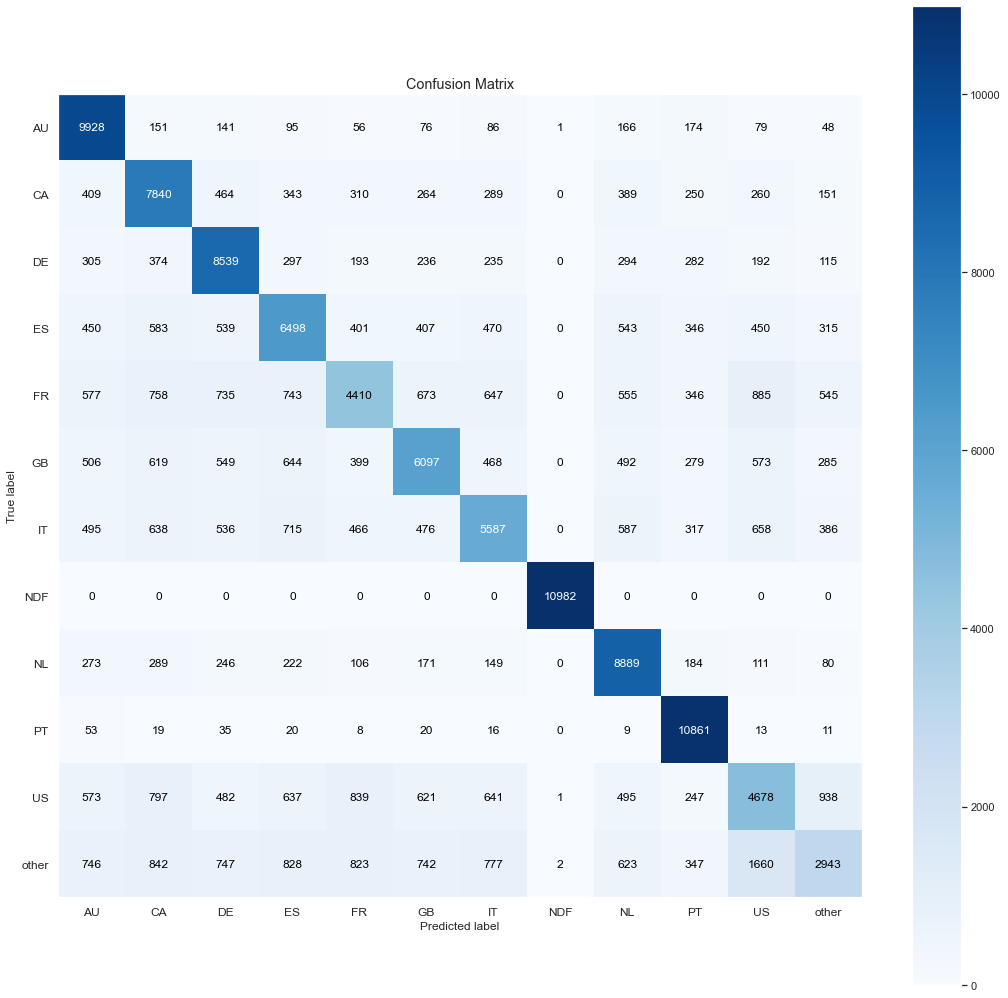

In [68]:
## CatBoost Classifier
# model definition
cat_model = CatBoostClassifier()

# model training
cat_model.fit(X_train, y_train)

# predict
yhat = cat_model.predict(X_test)

# scores
acc_nn = m.accuracy_score(y_test, yhat)
balance_acc_nn = m.balanced_accuracy_score(y_test, yhat)
kappa_nn = m.cohen_kappa_score(y_test, yhat)

# print
print('Accuracy: {}'.format(acc_nn))
print('Balanced Accuracy: {}'.format(balance_acc_nn))
print('Kappa Score: {}'.format(kappa_nn))
print(m.classification_report(y_test, yhat))

# confusion matrix
mt.plot_confusion_matrix(y_test, yhat, normalize=False, figsize=(18,18)) 

Accuracy: 0.20401174168297456
Balanced Accuracy: 0.16560473492355615
Kappa Score: -0.04787728408892633
              precision    recall  f1-score   support

          AU       0.02      0.03      0.03        87
          CA       0.04      0.22      0.06       216
          DE       0.05      0.11      0.07       164
          ES       0.06      0.09      0.07       319
          FR       0.04      0.09      0.05       736
          GB       0.09      0.15      0.11       361
          IT       0.07      0.14      0.09       420
         NDF       0.00      0.00      0.00     10962
          NL       0.06      0.12      0.08       105
          PT       0.06      0.23      0.10        31
          US       0.29      0.43      0.35      9606
       other       0.12      0.38      0.18      1521

    accuracy                           0.20     24528
   macro avg       0.08      0.17      0.10     24528
weighted avg       0.13      0.20      0.16     24528



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

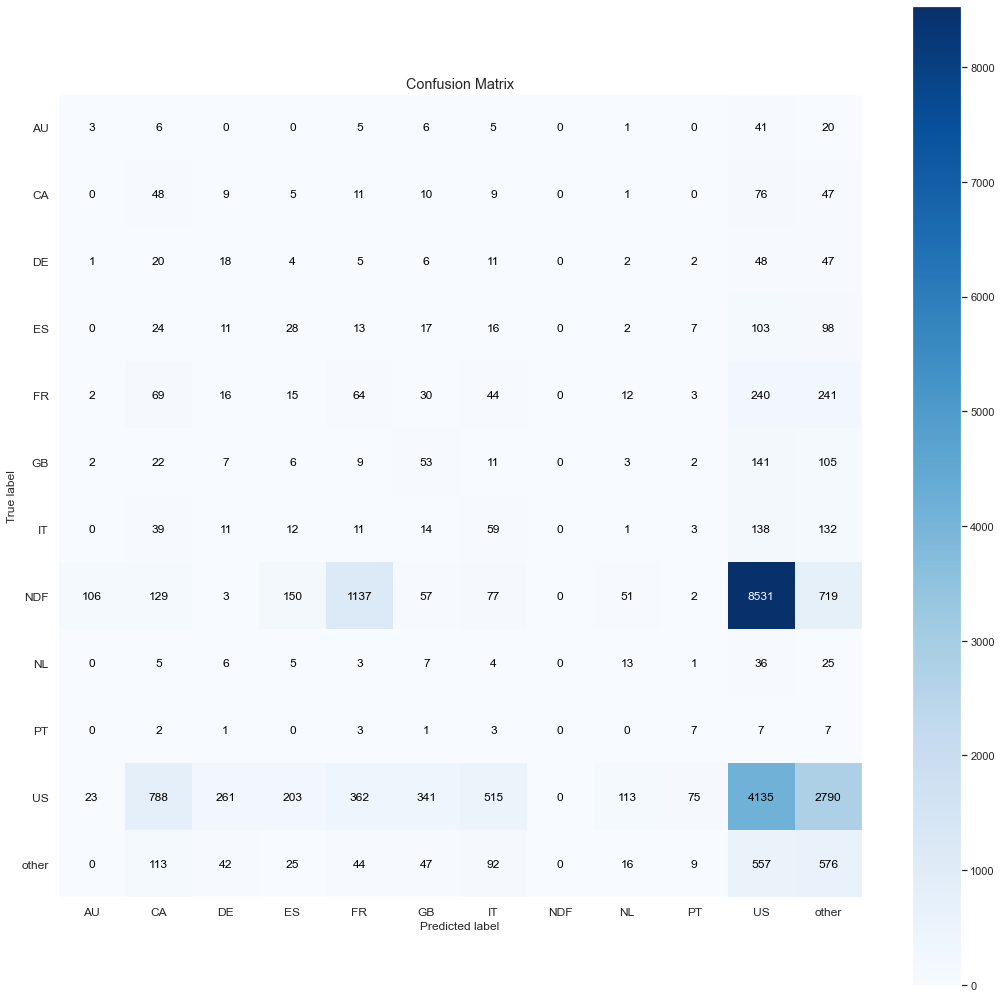

In [69]:
# predict
yhat = cat_model.predict(X_test_imb)

# scores
acc_nn = m.accuracy_score(y_test_imb, yhat)
balance_acc_nn = m.balanced_accuracy_score(y_test_imb, yhat)
kappa_nn = m.cohen_kappa_score(y_test_imb, yhat)

# print
print('Accuracy: {}'.format(acc_nn))
print('Balanced Accuracy: {}'.format(balance_acc_nn))
print('Kappa Score: {}'.format(kappa_nn))
print(m.classification_report(y_test_imb, yhat))

# confusion matrix
mt.plot_confusion_matrix(y_test_imb, yhat, normalize=False, figsize=(18,18)) 

In [9]:
classifiers = [['Logistic Regression', lm.LogisticRegression(verbose=0)],
               ['KNN', nh.KNeighborsClassifier(n_neighbors=2)],
               ['SVM', svm.LinearSVC()],
               ['Decision Tree', tree.DecisionTreeClassifier()],
               ['Random Forest Classifier', en.RandomForestClassifier()],
               ['XGBoost Classifier', XGBClassifier(verbosity=0)],
               ['CatBoost Classifier', CatBoostClassifier(verbose=False)]]

In [42]:
# cols_selected_1
cv_performance_models(df11[['age',
 'first_affiliate_tracked',
 'days_from_account_created_until_first_booking',
 'day_first_booking',
 'day_of_week_first_booking',
 'year_account_created',
 'day_account_created',
 'week_of_year_account_created',
 'week_of_year_account_created_sin',
 'week_of_year_account_created_cos',
 'day_of_week_first_booking_sin',
 'day_of_week_first_booking_cos',
 'day_account_created_sin',
 'day_account_created_cos',
 'day_of_week_account_created_sin',
 'day_of_week_account_created_cos', 'country_destination']], classifiers)

c:\users\lucas\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\users\lucas\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

KeyboardInterrupt: 

## NN perfomance - Cross-Validation

In [193]:
x_train = X_train

In [195]:
# generate k-fold for neural network classification:
        # Stratified K-Folds cross-validator, Provides train/test indices to split data in train/test sets. 
        # This cross-validation object is a variation of KFold that returns stratified folds. The folds are made by preserving the percentage of samples for each class.
num_folds = 5
kfold = ms.StratifiedKFold( n_splits=num_folds, shuffle=True, random_state=32 )

balanced_acc_list = []
kappa_acc_list = []

i = 1
for train_ix, val_ix in kfold.split( x_train, y_train ):
    print( 'Fold Number: {}/{}'.format( i, num_folds ) )
    
    # get fold
    x_train_fold = x_train.iloc[train_ix]
    y_train_fold = y_train.iloc[train_ix]
    
    x_val_fold = x_train.iloc[val_ix]
    y_val_fold = y_train.iloc[val_ix]
    
    # target hot-encoding
    ohe = pp.OneHotEncoder()
    y_train_fold_nn = ohe.fit_transform( y_train_fold.values.reshape( -1, 1 ) ).toarray()

    # model definition
    model = ml.Sequential()
    model.add( l.Dense( 256, input_dim=x_train.shape[1], activation='relu' ) )
    model.add( l.Dense( 12, activation='softmax') )

    # compile model
    model.compile( loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'] )

    # training model
    model.fit( x_train_fold, y_train_fold_nn, epochs=30, batch_size=32, verbose=0 )

    # prediction
    pred_nn = model.predict( x_val_fold )
    yhat_nn = ohe.inverse_transform( pred_nn )
    
    # prepare data
    y_test_nn = y_val_fold.to_numpy()
    yhat_nn = yhat_nn.reshape( 1, -1 )[0]

    # metrics
    ## Balanced Accuracy 
    balanced_acc_nn = m.balanced_accuracy_score( y_test_nn, yhat_nn )
    balanced_acc_list.append( balanced_acc_nn )
    
    ## Kappa Metrics
    kappa_acc_nn = m.cohen_kappa_score( y_test_nn, yhat_nn )
    kappa_acc_list.append( kappa_acc_nn )
    
    i += 1

Fold Number: 1/5
Fold Number: 2/5
Fold Number: 3/5
Fold Number: 4/5
Fold Number: 5/5


In [196]:
print( 'Avg Balanced Accuracy: {} +/- {}'.format( np.round( np.mean( balanced_acc_list ), 2 ), 
                                                  np.round( np.std( balanced_acc_list  ), 4 ) ) )
print( 'Avg Kappa: {} +/- {}'.format( np.round( np.mean( kappa_acc_list ), 4 ), 
                                      np.round( np.std( kappa_acc_list ), 4 ) ) )

Avg Balanced Accuracy: 0.11 +/- 0.0009
Avg Kappa: 0.1913 +/- 0.0066
